### Preprocess iEEG dataset

### 1. discard bad channels
### 2. notch filter for line noise
### 3. common average reference(raw_car)


In [90]:
class SubjectDataset(object):
    def __init__(self, input_root, subject, preload=True, **kwargs):
        self.root = input_root
        self.subject = subject
        self.datatype = 'ieeg'
        self.acquisition = None
        self.__dict__.update(kwargs)
        self.task = 'film'
        self.expected_duration = 390


        if preload:
            self._set_paths()
            self._load_data()
            self._get_bad_electrodes()
            
    def _set_paths(self):
        bids_path = mne_bids.BIDSPath(subject=self.subject,
                                      task=self.task,
                                      suffix='ieeg',
                                      extension='vhdr',
                                      datatype=self.datatype,
                                      acquisition=self.acquisition,
                                      root=self.root)

        print(self.task)
        assert len(bids_path.match()) == 1, 'None or more than one run for task is found'

        self.raw_path = str(bids_path.match()[0])
        self.run = mne_bids.get_entities_from_fname(bids_path.match()[0])['run']
        self.session = mne_bids.get_entities_from_fname(bids_path.match()[0])['session']

        bids_path = mne_bids.BIDSPath(subject=self.subject,
                                      task=self.task,
                                      session=self.session,
                                      suffix='channels', run=self.run,
                                      extension='tsv',
                                      datatype=self.datatype,
                                      acquisition=self.acquisition,
                                      root=self.root)
        self.channels_path=str(bids_path)

        bids_path = mne_bids.BIDSPath(subject=self.subject,
                                      session=self.session, suffix='electrodes',
                                      extension='tsv',
                                      datatype=self.datatype,
                                      acquisition=self.acquisition,
                                      root=self.root)
        self.electrodes_path = str(bids_path)

        bids_path = mne_bids.BIDSPath(subject=self.subject,
                                      suffix='T1w',
                                      extension='.nii.gz',
                                      root=self.root)
        self.anat_path = str(bids_path.match()[0])
        self.anat_session = mne_bids.get_entities_from_fname(bids_path.match()[0])['session']
        print('Picking up BIDS files done')


    def _load_data(self):
        self.raw = mne.io.read_raw_brainvision(self.raw_path,
                                               eog=(['EOG']),
                                               misc=(['OTHER', 'ECG', 'EMG']),
                                               scale=1.0,
                                               preload=False,
                                               verbose=True)
        self.channels = pd.read_csv(self.channels_path, sep='\t', header=0, index_col=None)
        self.electrodes = pd.read_csv(self.electrodes_path, sep='\t', header=0, index_col=None)
        self.raw.set_channel_types({ch_name: str(x).lower()
                                if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
                                    for ch_name, x in zip(self.raw.ch_names, self.channels['type'].values)})
        self.other_channels = self.channels['name'][~self.channels['type'].isin(['ECOG', 'SEEG'])].tolist()
        self.raw.drop_channels(self.other_channels)
        print('Loading BIDS data done')


    def _get_bad_electrodes(self):
        self.bad_electrodes = self.channels['name'][
            (self.channels['type'].isin(['ECOG', 'SEEG'])) & (self.channels['status'] == 'bad')].tolist()
        self.all_electrodes = self.channels['name'][(self.channels['type'].isin(['ECOG', 'SEEG']))].tolist()
        print('Getting bad electrodes done')

        
    def preprocess(self):
        raw_dbe=self._discard_bad_electrodes()
        raw_nf=self._notch_filter()
        raw_car=self._common_average_reference()
        return raw_car


    def _discard_bad_electrodes(self):
        if self.raw is not None:
            [self.bad_electrodes.remove(i) for i in self.bad_electrodes if i not in self.raw.ch_names]
            self.raw.info['bads'].extend([ch for ch in self.bad_electrodes])
            print('Bad channels indicated: ' + str(self.bad_electrodes))
            print('Dropped ' + str(self.raw.info['bads']) + 'channels')
            self.raw.drop_channels(self.raw.info['bads'])
            self.raw.load_data()
            print('Remaining channels ' + str(self.raw.ch_names))
            return self.raw


    def _notch_filter(self):
        if self.raw is not None:
            if np.any(np.isnan(self.raw._data)):
                # self.raw._data[np.isnan(self.raw._data)]=0 # bad hack for nan values
                warnings.warn('There are NaNs in the data, replacing with 0')
            self.raw.notch_filter(freqs=np.arange(50, 251, 50))
            print('Notch filter done')
        return self.raw


    def _common_average_reference(self):
        if self.raw is not None:
            self.raw_car, _ = mne.set_eeg_reference(self.raw.copy(), 'average')
            print('CAR done')
        return self.raw_car


    def extract_events(self, plot=True):
        events,events_id=self._read_events()
        if plot:
            self._plot_events()
        return events,events_id


    def _read_events(self):
        if self.raw is not None:
            if self.task == 'film':
                custom_mapping = {'Stimulus/music': 2,
                                  'Stimulus/speech': 1,
                                  'Stimulus/end task': 5}
            elif self.task == 'rest':
                custom_mapping = {'Stimulus/start task': 1,
                                  'Stimulus/end task': 2}
            else:
                raise NotImplementedError
            self.events, self.event_id = mne.events_from_annotations(self.raw, event_id=custom_mapping,
                                                                     use_rounding=False)
            print('Reading events done')
        return self.events, self.event_id


    def _plot_events(self):
        if self.raw_car is not None:
            self.raw_car.plot(events=self.events,
                              start=0,
                              duration=180,
                              color='gray',
                              event_color={2: 'g', 1: 'r'},
                              bgcolor='w')


    def extract_bands(self, smooth=False):
        if self.raw_car is not None:
            bands2=self._compute_band_envelopes()
            bands3=self._crop_band_envelopes()
            bands4=self._resample_band_envelopes()
            if smooth: self._smooth_band_envelopes()
            bands5,bands6,band_block_means=self._compute_block_means_per_band()
        return bands2,bands3,bands4,bands5


    def _compute_band_envelopes(self):
        if self.raw_car is not None:
            bands = {'delta': [1, 4], 'theta': [5, 8], 'alpha': [8, 12], 'beta': [13, 24], 'gamma': [60, 120]}
            self.bands1 = OrderedDict.fromkeys(bands.keys())
            for key in self.bands1.keys():
                self.bands1[key] = self.raw_car.copy().filter(bands[key][0], bands[key][1]).apply_hilbert(
                    envelope=True).get_data().T
            print('Extracting band envelopes done')
        return self.bands1


    def _crop_band_envelopes(self):
        if self.bands1 is not None:
            self.bands2 = OrderedDict.fromkeys(self.bands1.keys())
            for key in self.bands1.keys():
                self.bands2[key] = self.bands1[key][self.events[0, 0]:self.events[-1, 0]]
        return self.bands2


    def _resample_band_envelopes(self):
        if self.bands1 is not None:
            self.bands3 = OrderedDict.fromkeys(self.bands1.keys())
            for key in self.bands1.keys():
                self.bands3[key] = resample(self.bands2[key], 25, int(self.raw.info['sfreq']))
        return self.bands3



    def _smooth_band_envelopes(self):
        if self.bands1 is not None:
            for key in self.bands1.keys():
                self.bands[key] = np.apply_along_axis(smooth_signal, 0, self.bands[key], 5)


    def _compute_block_means_per_band(self):
        if self.bands1 is not None:
            self.band_block_means = OrderedDict.fromkeys(self.bands1.keys())
            band6=OrderedDict.fromkeys(self.bands1.keys())
            for key in self.bands1.keys():
                band6[key] = zscore(self.bands3[key][:self.expected_duration * 25])
                band7 = band6[key].reshape((-1, 750, band6[key].shape[-1]))  # 13 blocks in chill or 6 in rest
                self.band_block_means[key] = np.mean(band7, 1)
        return band6,band7,self.band_block_means
        

### 4. extract signal in five frequency bands (Hilbert transform, take envelope): delta, theta, alpha, beta nad high broadband gamma

### 5. downsample to 25 Hz

### definition output:
### 1.bands2= output of "def _compute_band_envelopes" contains each band in fs=2048 & time duration =420s
### 2.bands3= output of "def  _crop_band_envelopes" contains each band in fs=2048 & time duration =390s
 
note= time duration of raw signal is 420s but time duration of raw film is 390s so by "def _crop_band_envelopes", time of signal correct

### 3.bands4= output of "def  _resample_band_envelopes" contains each band in fs=25 & time duration =420s
### 4.bands5=output of "def  _compute_block_means_per_band" calculate Zscore of singal in each bands


In [ ]:
import mne_bids
import mne
import pandas as pd
import os
import numpy as np
from collections import OrderedDict
from ieeg_fmri_validation.utils import resample, smooth_signal, zscore

num=63
bids_dir='E:\maryam.sh'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')
subject=subjects[0]
acqs=mne_bids.get_entity_vals(os.path.join(bids_dir, 'sub-' + subject, 'ses-iemu', 'ieeg'),'acquisition')
acq=acqs[0]
band_all_patient=[]
raw_car_all=[]
i=0
subjects2=subjects[:num]
for subject in subjects2:
     if 'iemu' in mne_bids.get_entity_vals(os.path.join(bids_dir, 'sub-' + subject), 'session'):
        i=i+1
        s=SubjectDataset(bids_dir,subject,acquisition=acq)
        raw_car=s.preprocess()
        events,events_id=s.extract_events()
        bands2,bands3,bands4,band5=s.extract_bands()
        band_all_patient.append(band5['gamma'])
        raw_car_all.append(raw_car)
    
    

### save and load band_all_patient and raw_car_all

In [ ]:
import pickle 

with open('rr.txt','wb') as f:
    pickle.dump(band_all_patient,f)

#with open('rr.txt','rb') as f:
#    band_all_patient=pickle.load(f)
    
#with open('raw_car_all.txt','wb') as f:
#    pickle.dump(raw_car_all,f)
    
#with open('raw_car_all.txt','rb') as f:
#    raw_car_all=pickle.load(f)
#with open('band_all_patient_same.txt','wb') as f:
#    pickle.dump(band_all_patient_same,f)

#with open('raw_car_all_same.txt','wb') as f:
#    pickle.dump(raw_car_all_same,f)

### calculate histogram of electrodes of patients(h)

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

d=[]
for i in range(len(raw_car_all)):
    elec_list=raw_car_all[i].ch_names
    d=[*d,*elec_list]
    
#plt.figure(figsize=(30,10))    
#plt.hist(d)
#plt.show()

h=Counter(d)


In [9]:
h.elements

<bound method Counter.elements of Counter({'T01': 23, 'T04': 23, 'T05': 23, 'T07': 23, 'T02': 22, 'T03': 22, 'T06': 22, 'T08': 20, 'T09': 19, 'T10': 19, 'T11': 19, 'T12': 19, 'T13': 19, 'T14': 19, 'F01': 16, 'F03': 16, 'F05': 16, 'F06': 16, 'F07': 16, 'F08': 16, 'T15': 16, 'F02': 15, 'F04': 15, 'F11': 14, 'F12': 14, 'F13': 14, 'F14': 14, 'F15': 14, 'F16': 14, 'sT1': 14, 'sT2': 14, 'sT3': 14, 'sT4': 14, 'T16': 14, 'vT1': 14, 'vT3': 14, 'vT4': 14, 'vT6': 14, 'F09': 13, 'F10': 13, 'F17': 13, 'F18': 13, 'F19': 13, 'F20': 13, 'F21': 13, 'F22': 13, 'F23': 13, 'F24': 13, 'F28': 13, 'F30': 13, 'F31': 13, 'sT5': 13, 'T18': 13, 'T19': 13, 'T20': 13, 'T21': 13, 'T22': 13, 'T23': 13, 'T25': 13, 'T26': 13, 'T27': 13, 'T28': 13, 'T30': 13, 'T31': 13, 'T32': 13, 'vT2': 13, 'vT5': 13, 'F27': 12, 'F29': 12, 'F32': 12, 'T17': 12, 'T24': 12, 'T29': 12, 'F25': 11, 'F26': 11, 'vT7': 11, 'C01': 10, 'C02': 10, 'C03': 10, 'C04': 10, 'C05': 10, 'C06': 10, 'C07': 10, 'F33': 9, 'F34': 9, 'F35': 9, 'F36': 9, 'F37

In [10]:
elec_more_one=[]
elec_more_ten=[]
elec_more_fifteen=[]
elec_more_tweny=[]
elec_more_thirty=[]


for key in h.keys():
    if(h[key]>1):
        elec_more_one.append(key) 
    if(h[key]>10):
        elec_more_ten.append(key)
    if(h[key]>15):
        elec_more_fifteen.append(key)
    if(h[key]>20):
        elec_more_tweny.append(key)
   
    

print('number of total electrode is =' , len(h) ,'\nmax number of electrod is same=',23)    

print('number of electrod that are same in more than one patient = ', len(elec_more_one))
print('number of electrod that are same in more than ten patient = ' ,len(elec_more_ten))
print('number of electrod that are same in more than fifteen patient = ' ,len(elec_more_fifteen))
print('number of electrod that are same in more than tweny patient = ', len(elec_more_tweny))


print('\n\n',elec_more_fifteen,'elec_more_fifteen\n\n')

print(elec_more_tweny,'elec_more_tweny')

number of total electrode is = 1522 
max number of electrod is same= 23
number of electrod that are same in more than one patient =  540
number of electrod that are same in more than ten patient =  76
number of electrod that are same in more than fifteen patient =  21
number of electrod that are same in more than tweny patient =  7


 ['F01', 'F03', 'F05', 'F06', 'F07', 'F08', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T08', 'T15'] elec_more_fifteen


['T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07'] elec_more_tweny


In [11]:
elec= {'F01':[] , 'F03':[] , 'F05': [] , 'F06':[] , 'F07':[] , 'F08':[] , 'T01':[] , 'T02':[] , 'T03':[] , 'T04':[] , 'T05':[] , 'T06':[], 'T07':[], 'T09':[], 'T10':[], 'T11':[], 'T12':[], 'T13':[], 'T14':[], 'T08':[], 'T15':[]}

for i in range(len(raw_car_all)):
    for key in elec.keys():
        if key in raw_car_all[i].ch_names:
            elec[key].append(i)

for key in elec.keys():
    print('\n  ' ,key, '=', elec[key])


   F01 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   F03 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   F05 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   F06 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   F07 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   F08 = [1, 2, 4, 8, 10, 14, 15, 20, 22, 26, 31, 34, 36, 41, 42, 45]

   T01 = [2, 3, 4, 12, 15, 17, 19, 21, 22, 23, 28, 29, 31, 33, 34, 36, 37, 38, 40, 42, 44, 45, 46]

   T02 = [2, 3, 4, 12, 15, 17, 19, 21, 22, 28, 29, 31, 33, 34, 36, 37, 38, 40, 42, 44, 45, 46]

   T03 = [2, 3, 12, 15, 17, 19, 21, 22, 23, 28, 29, 31, 33, 34, 36, 37, 38, 40, 42, 44, 45, 46]

   T04 = [2, 3, 4, 12, 15, 17, 19, 21, 22, 23, 28, 29, 31, 33, 34, 36, 37, 38, 40, 42, 44, 45, 46]

   T05 = [2, 3, 4, 12, 15, 17, 19, 21, 22, 23, 28, 29, 31, 33, 34, 36, 37, 38, 40, 42, 44, 45, 46]

   T06 = [2, 4, 12, 15, 17, 19, 21, 22, 23, 28, 29, 31, 33, 34, 36, 37, 38, 40, 

### plot average gamma band for common electrodes ( fs =25 HZ)


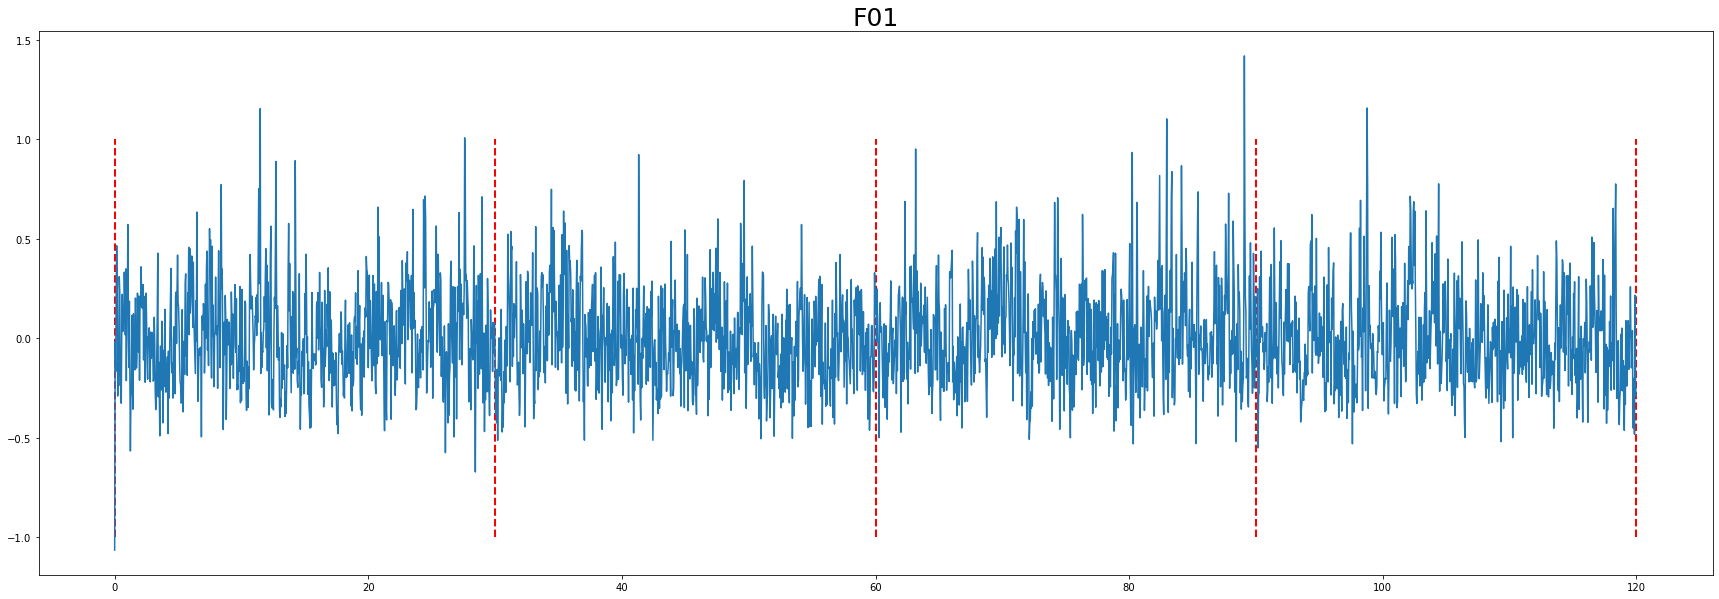

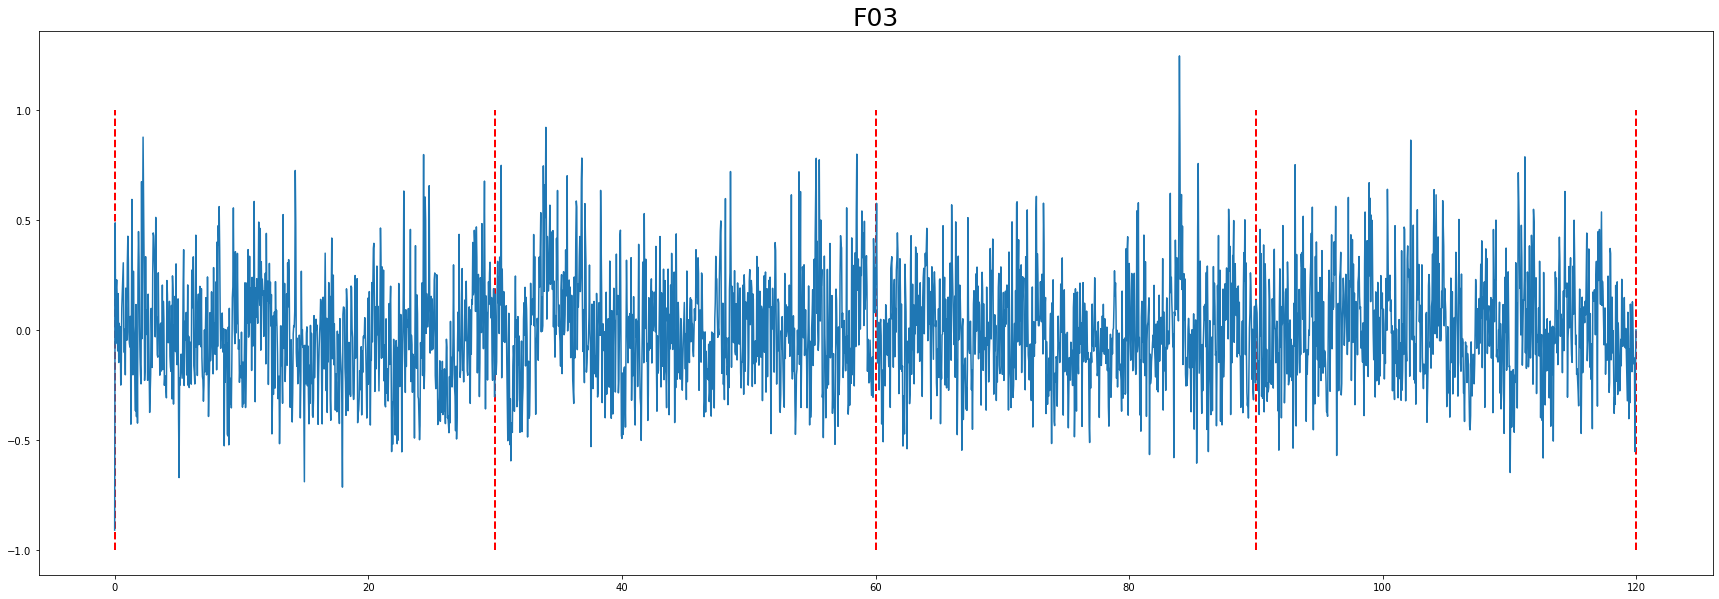

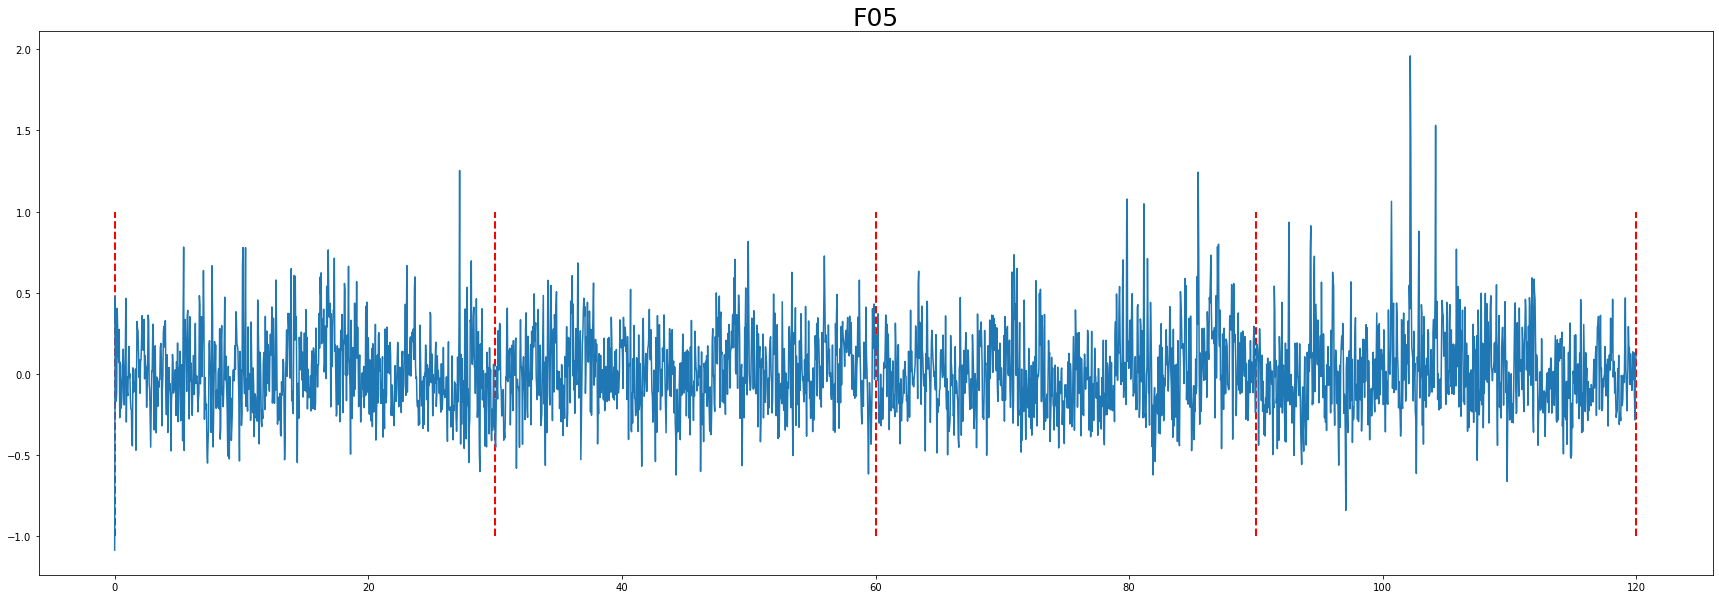

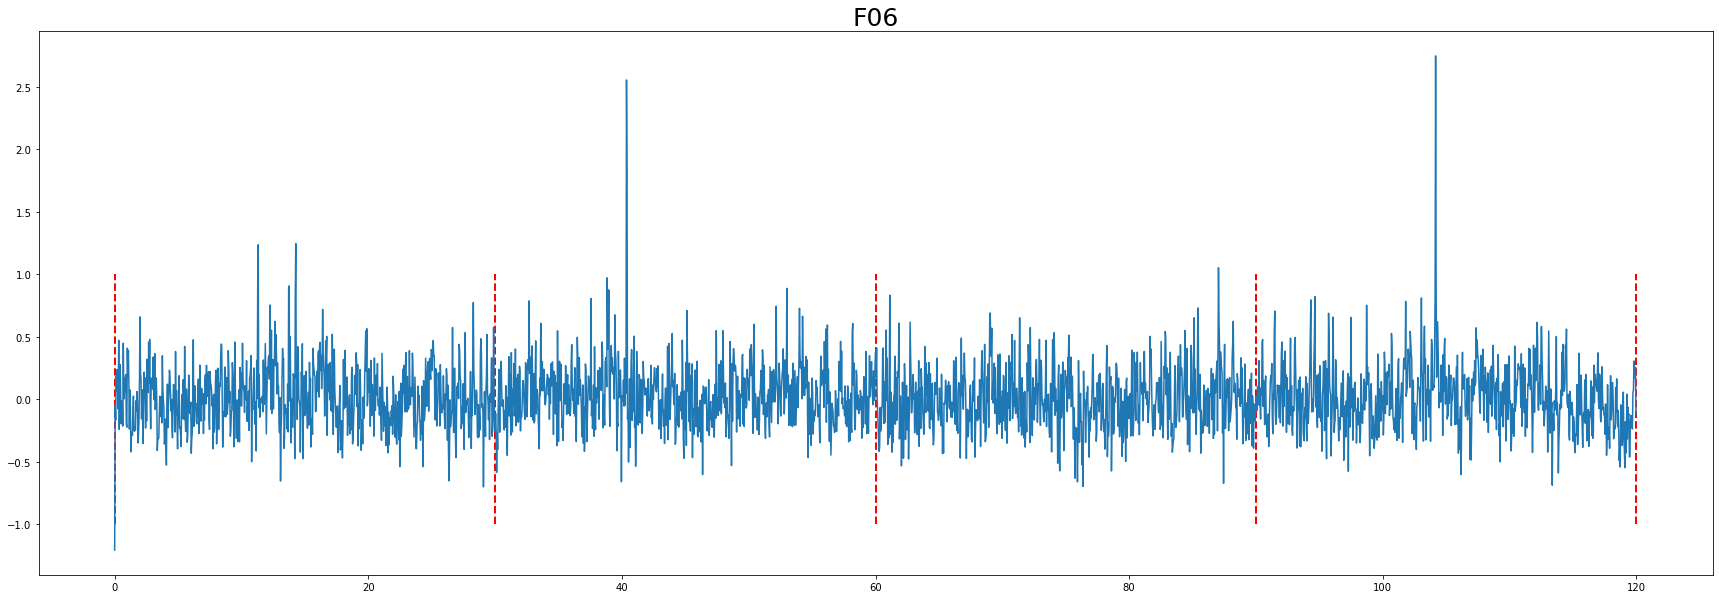

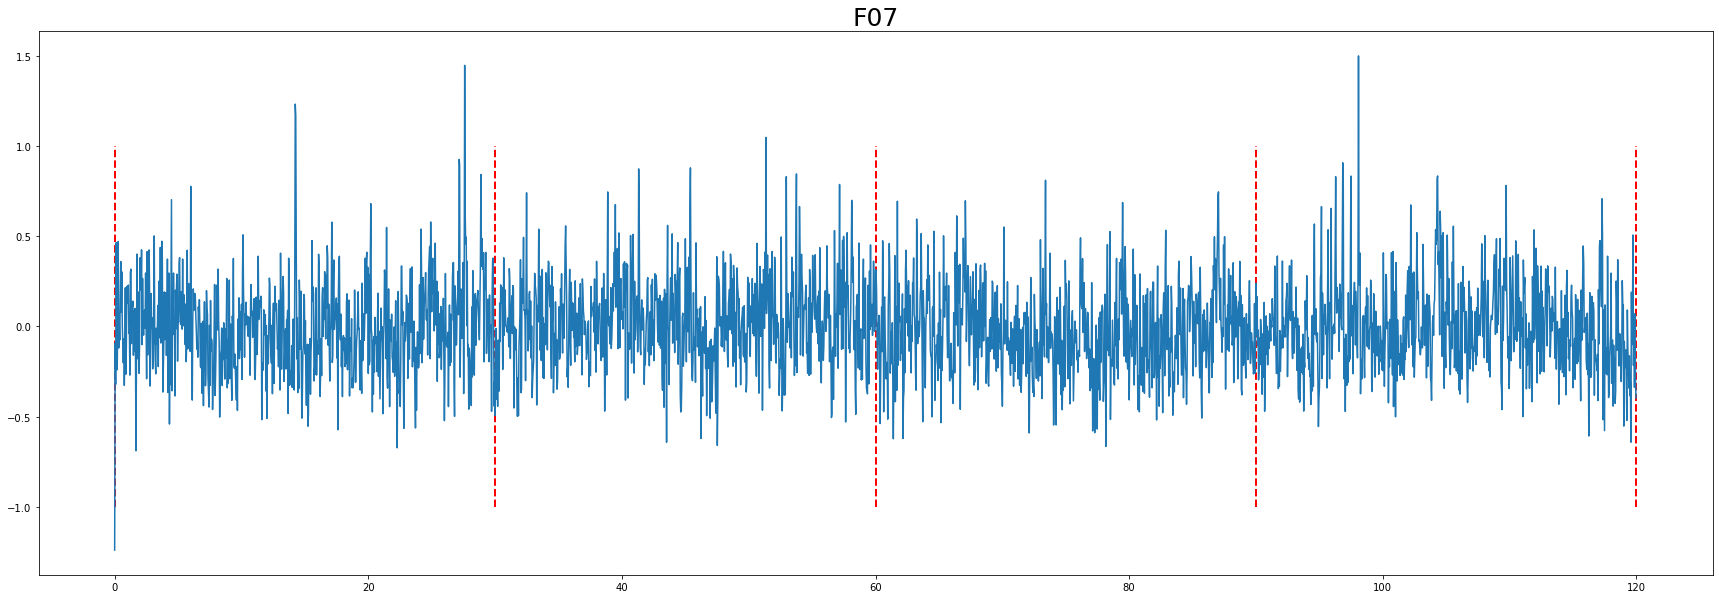

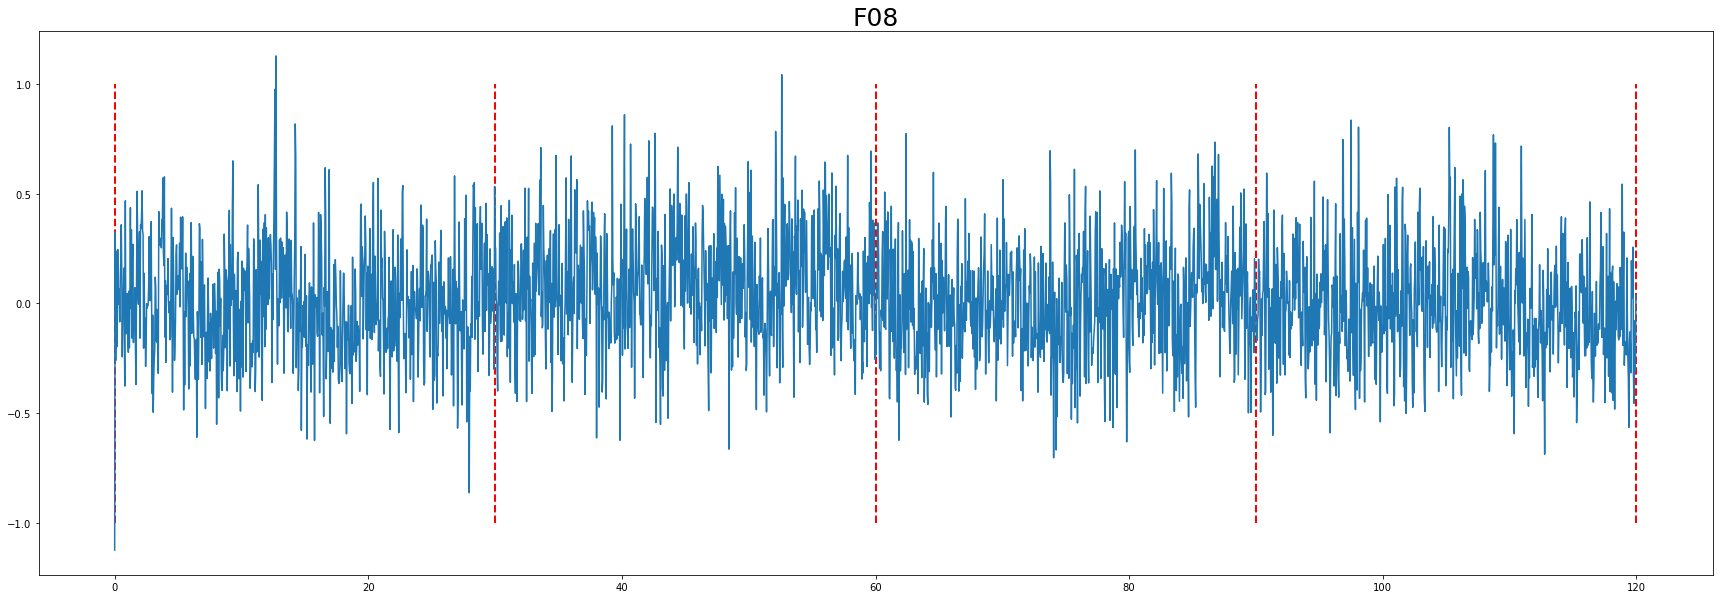

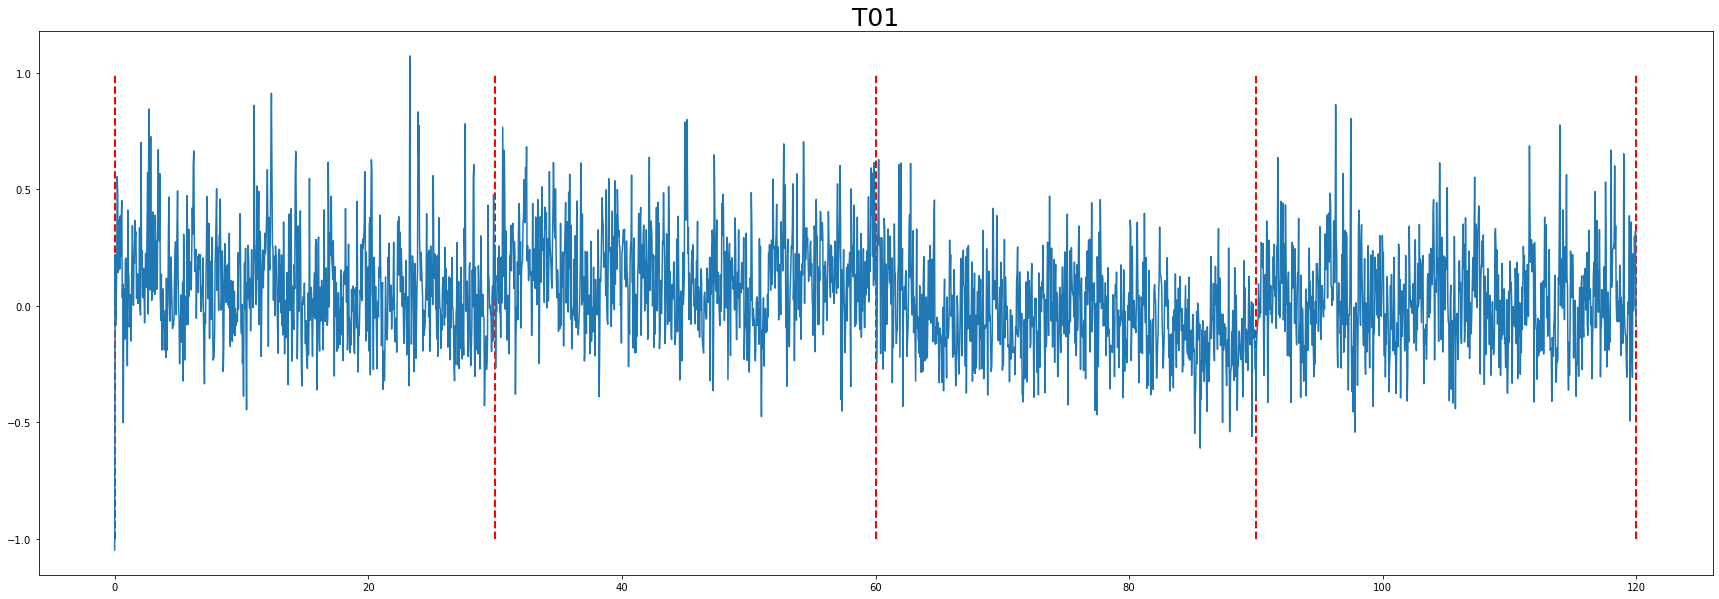

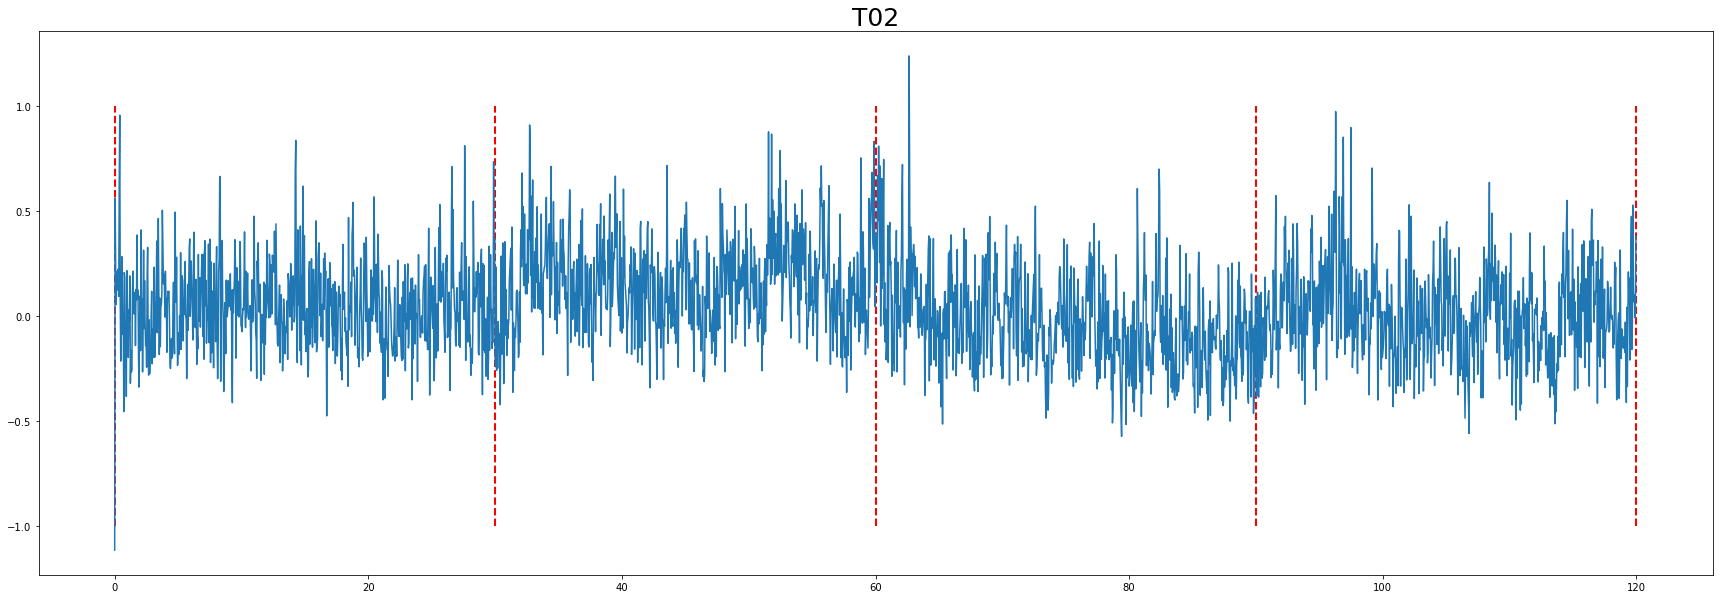

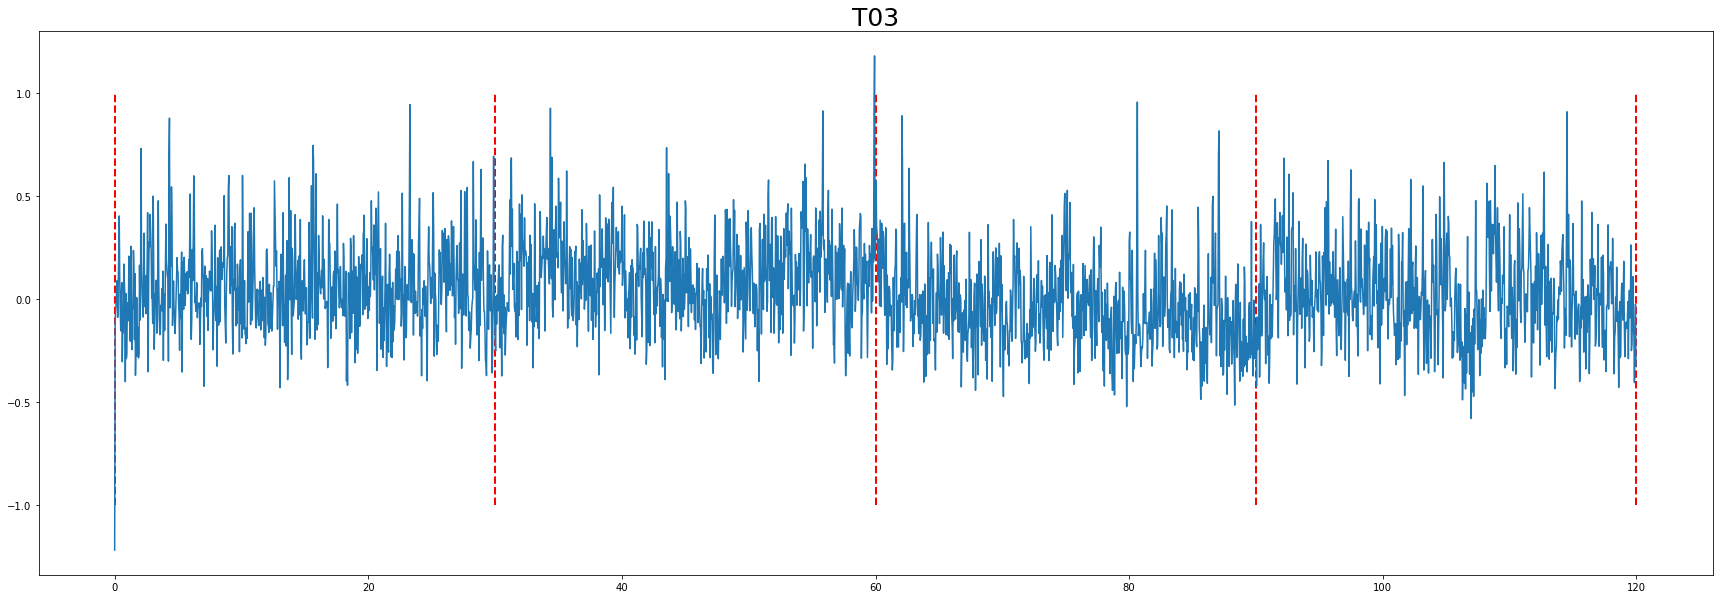

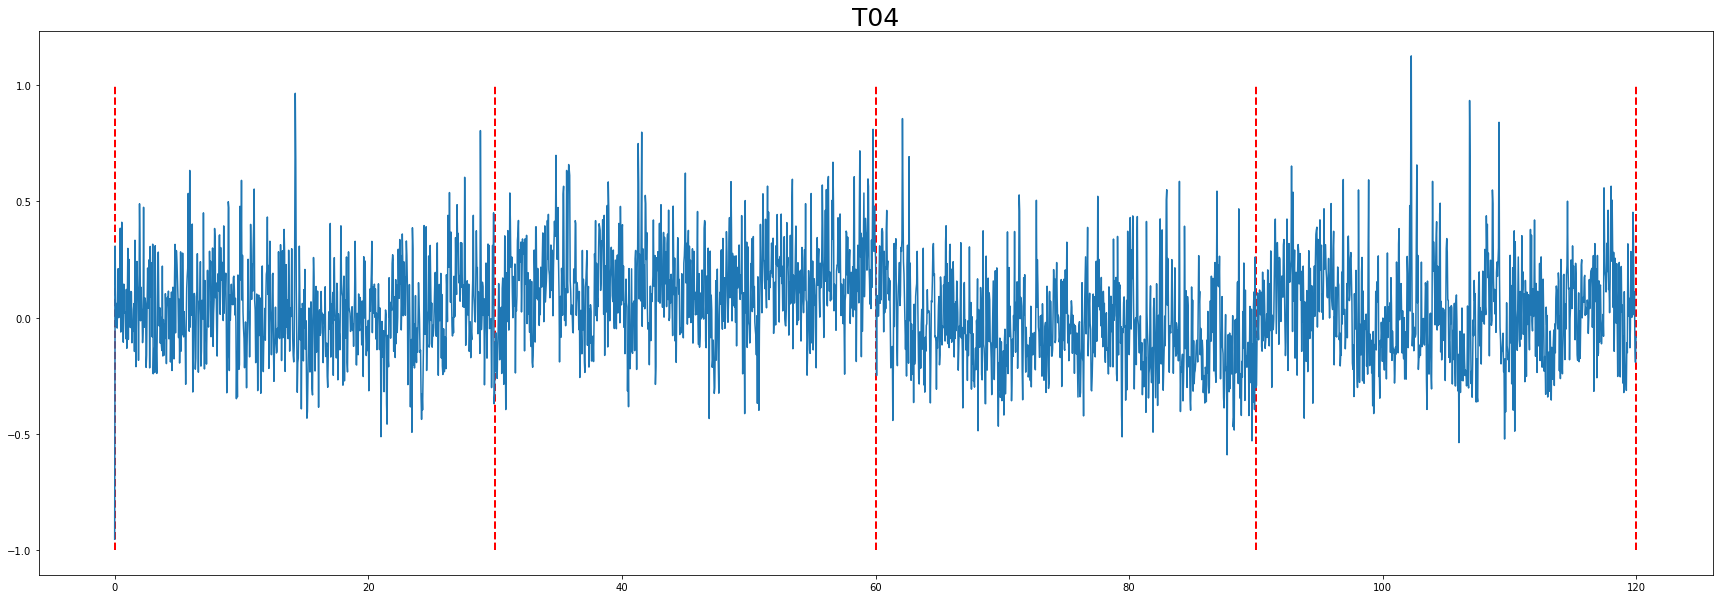

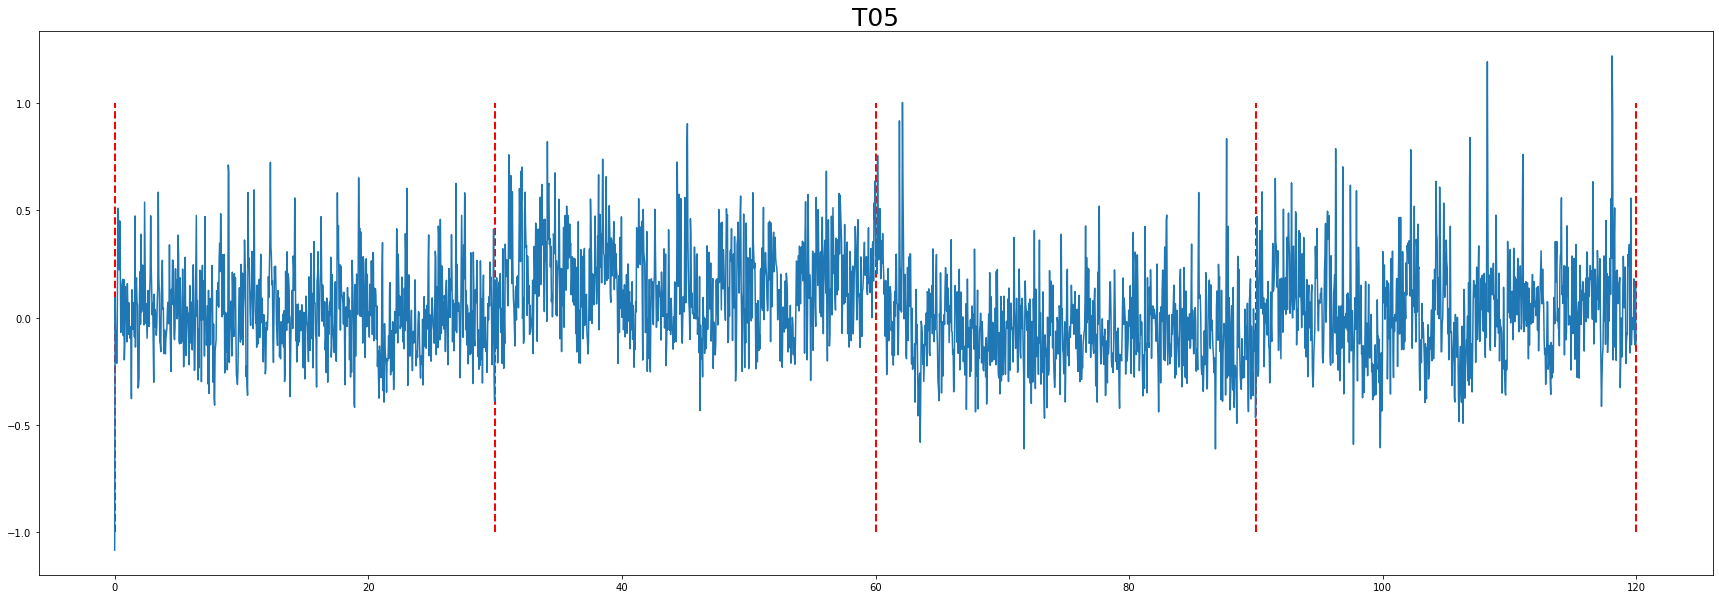

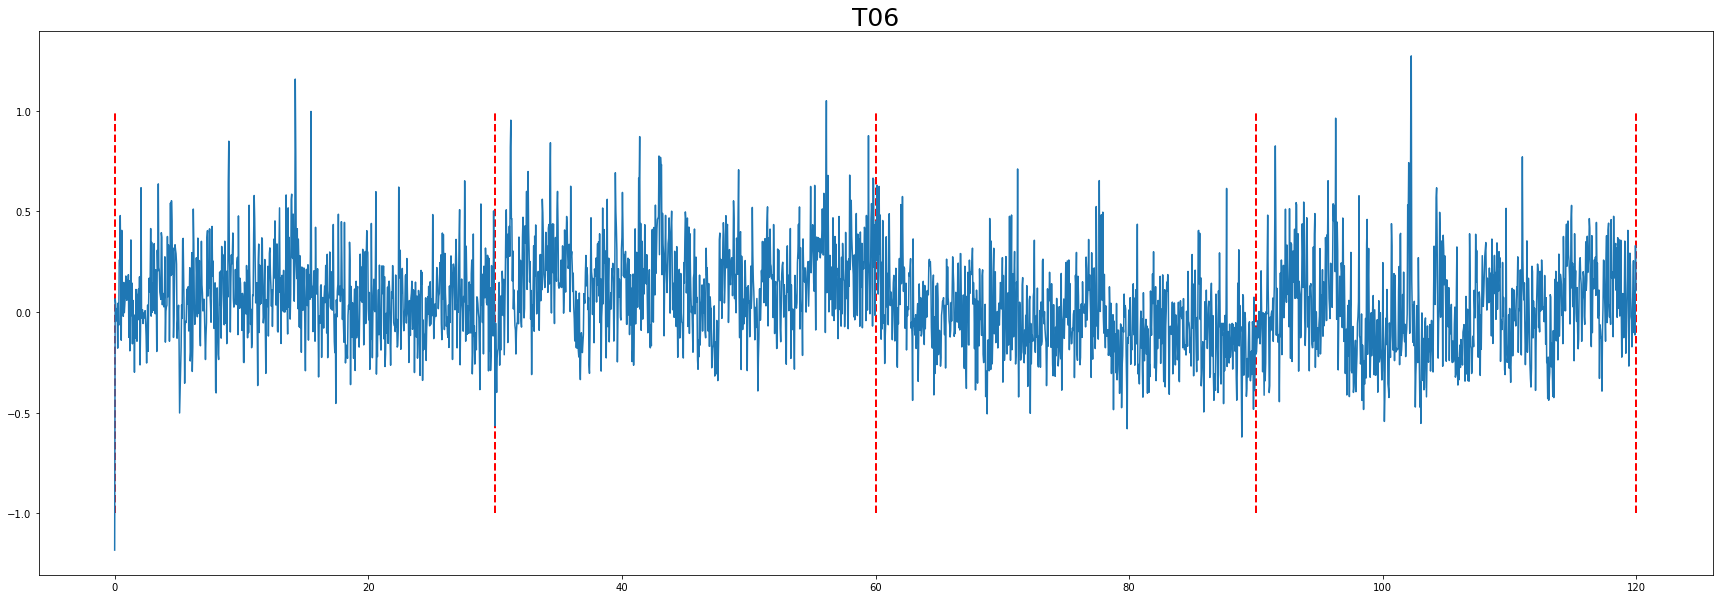

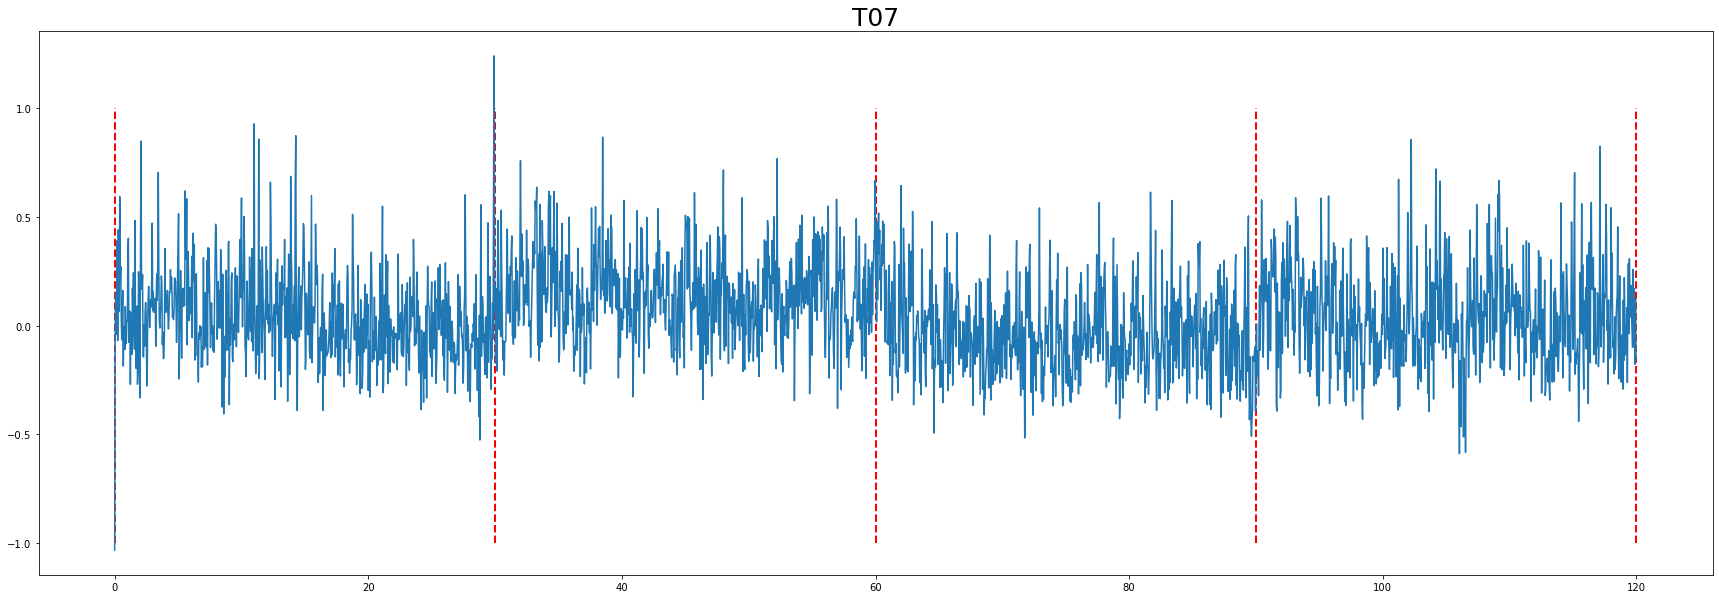

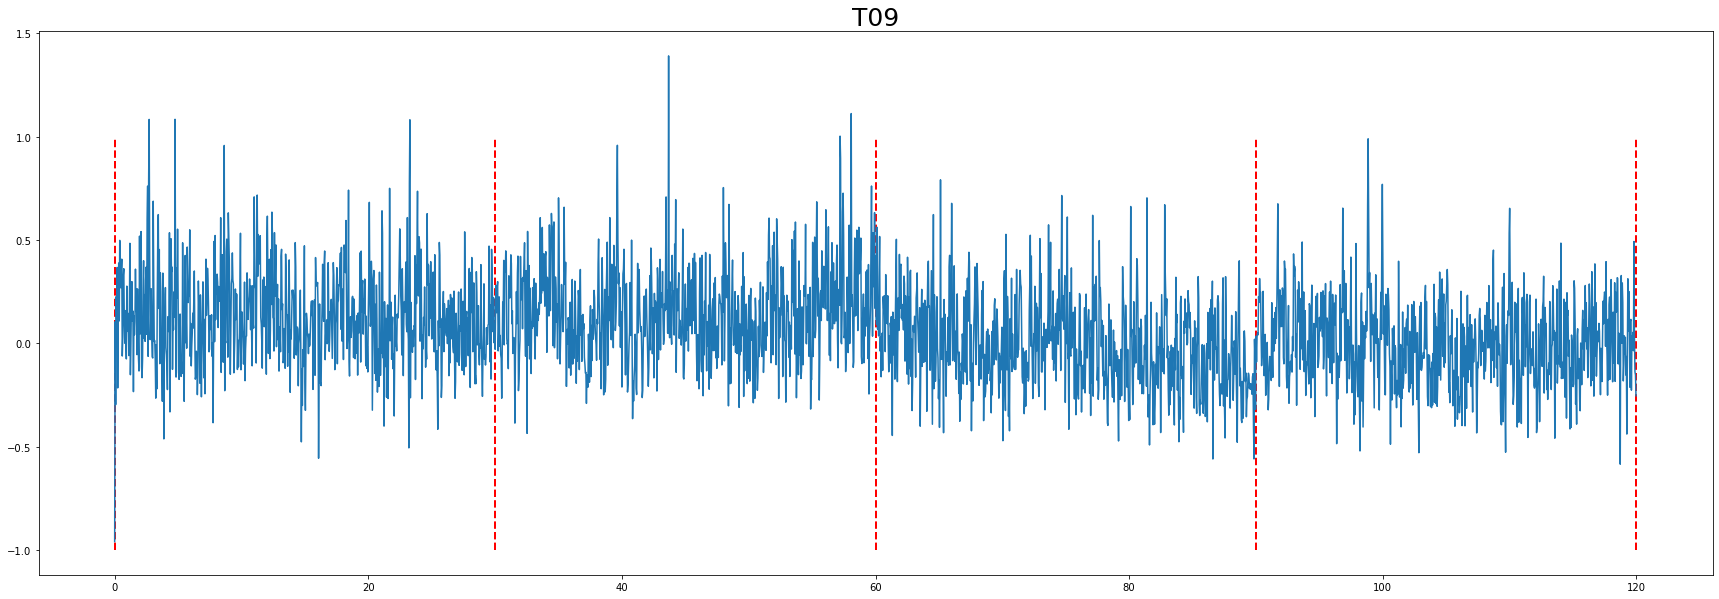

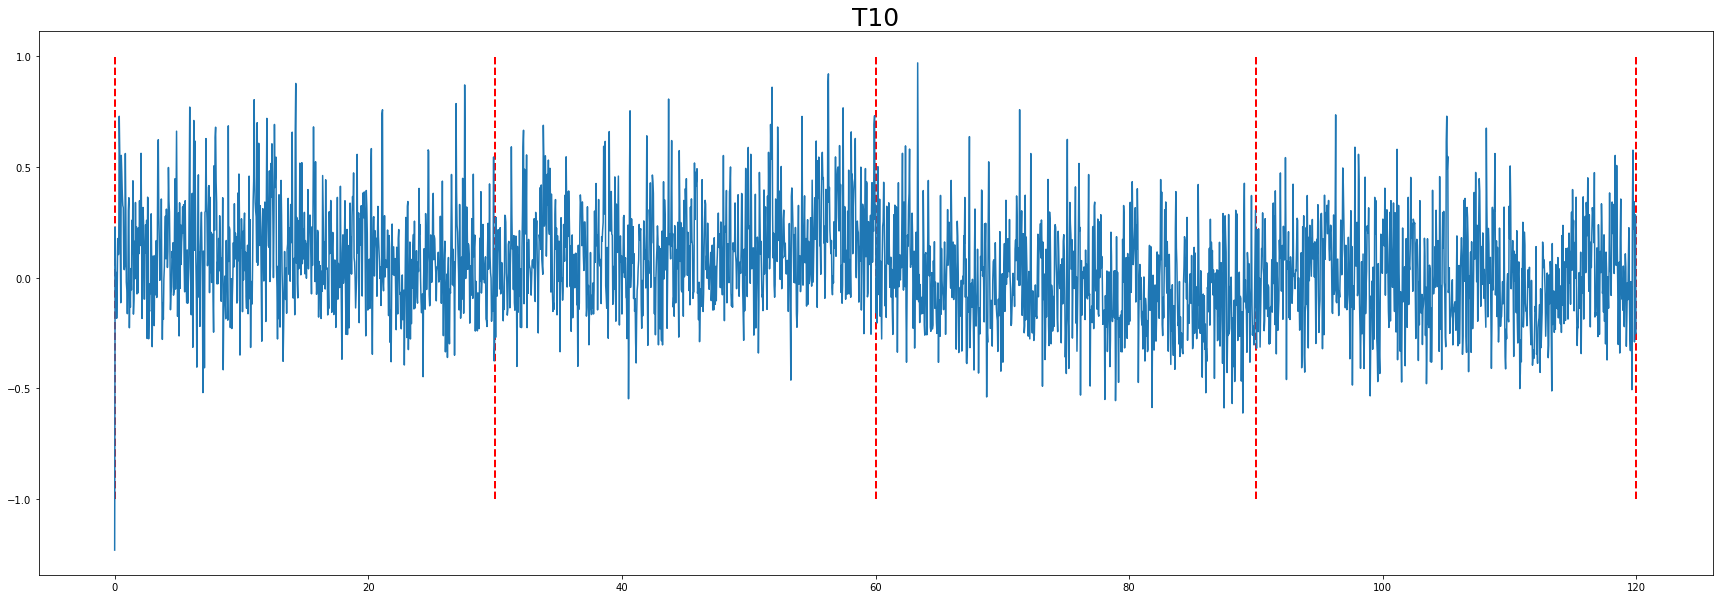

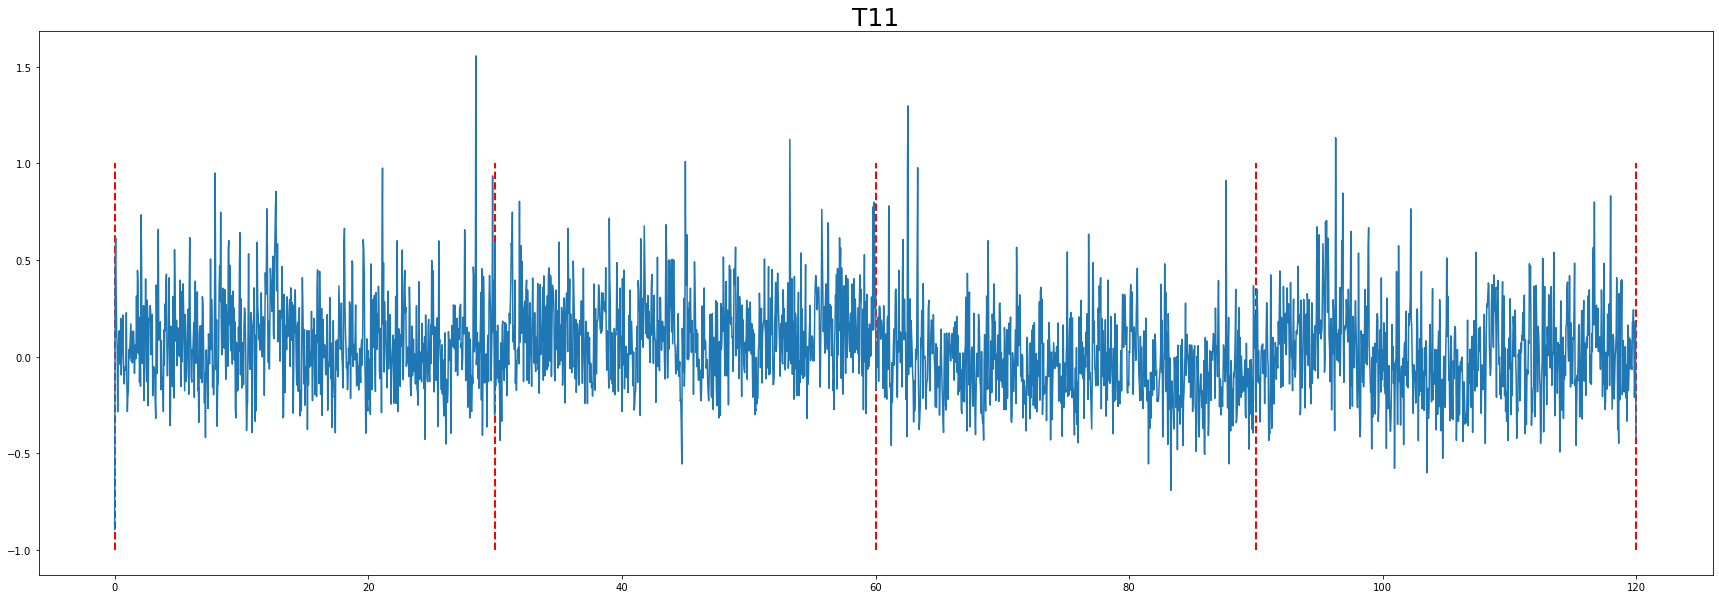

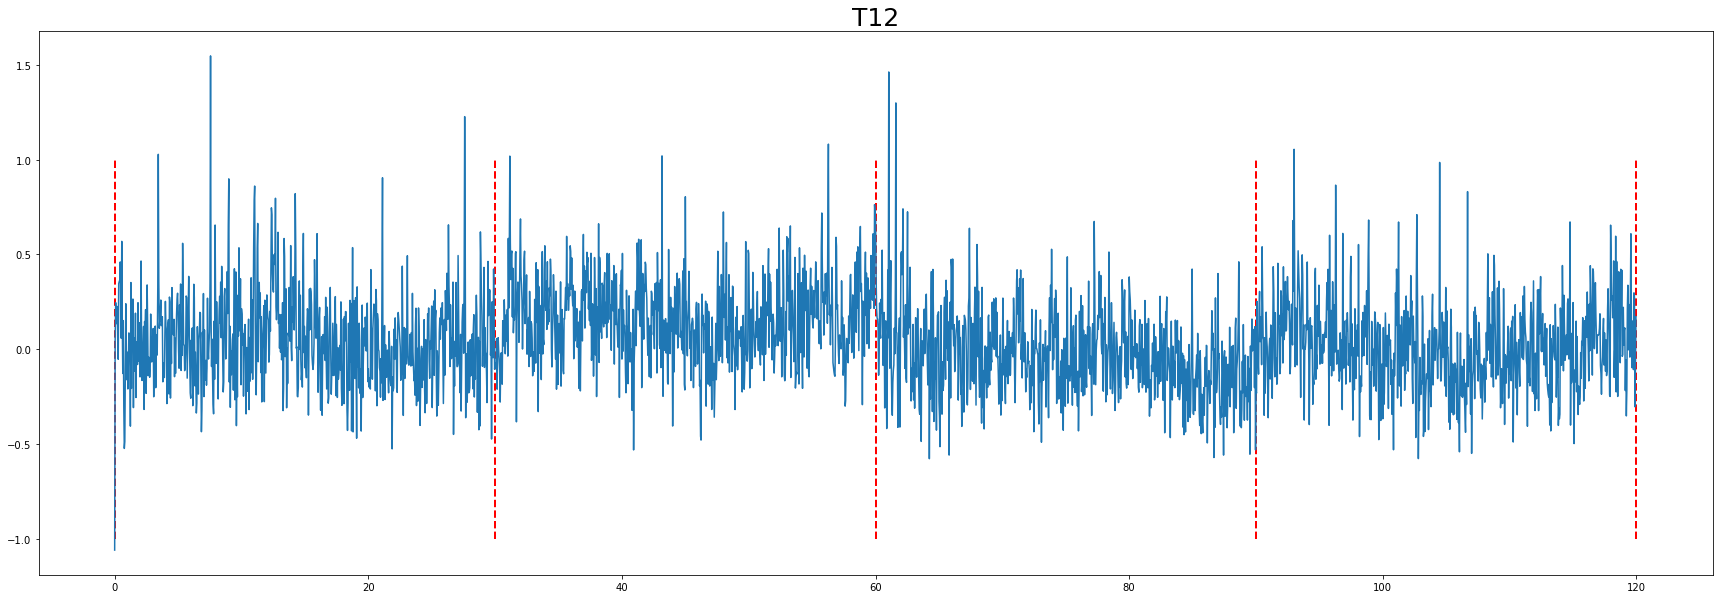

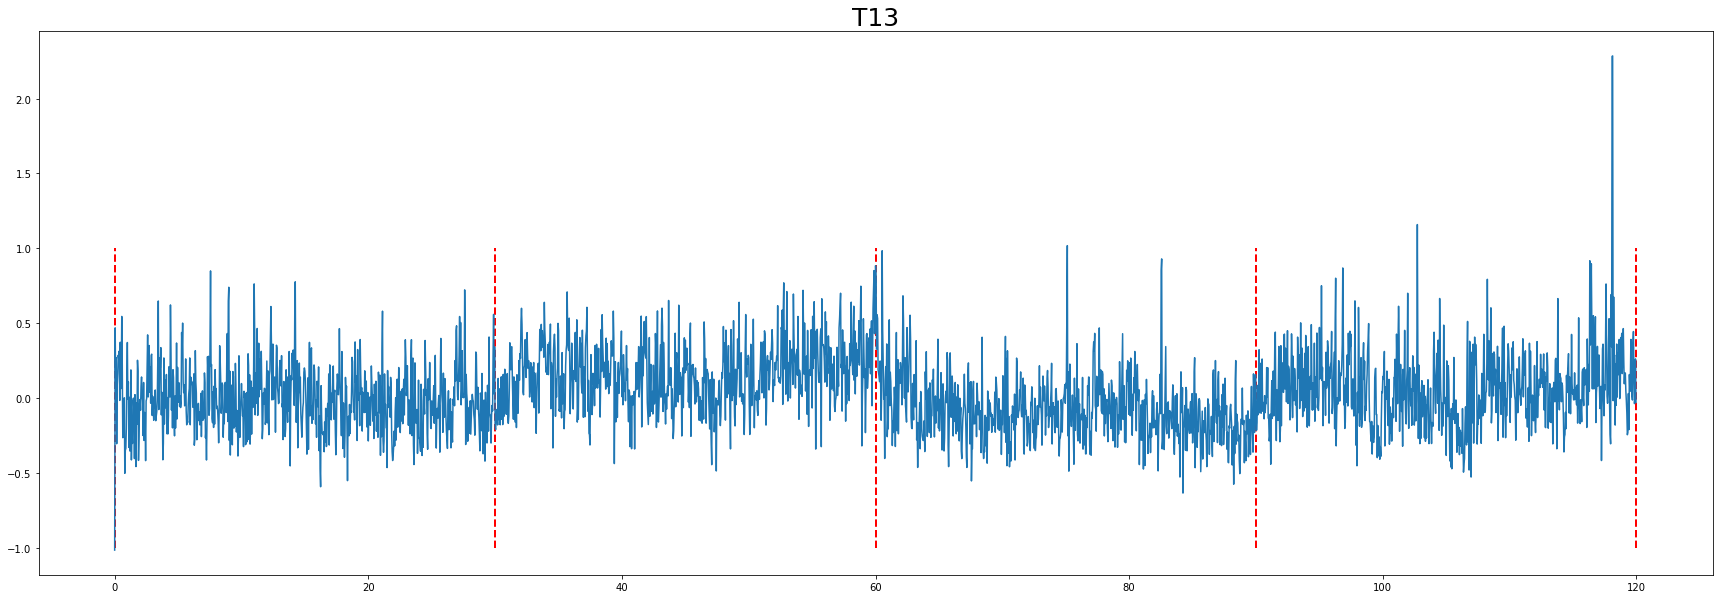

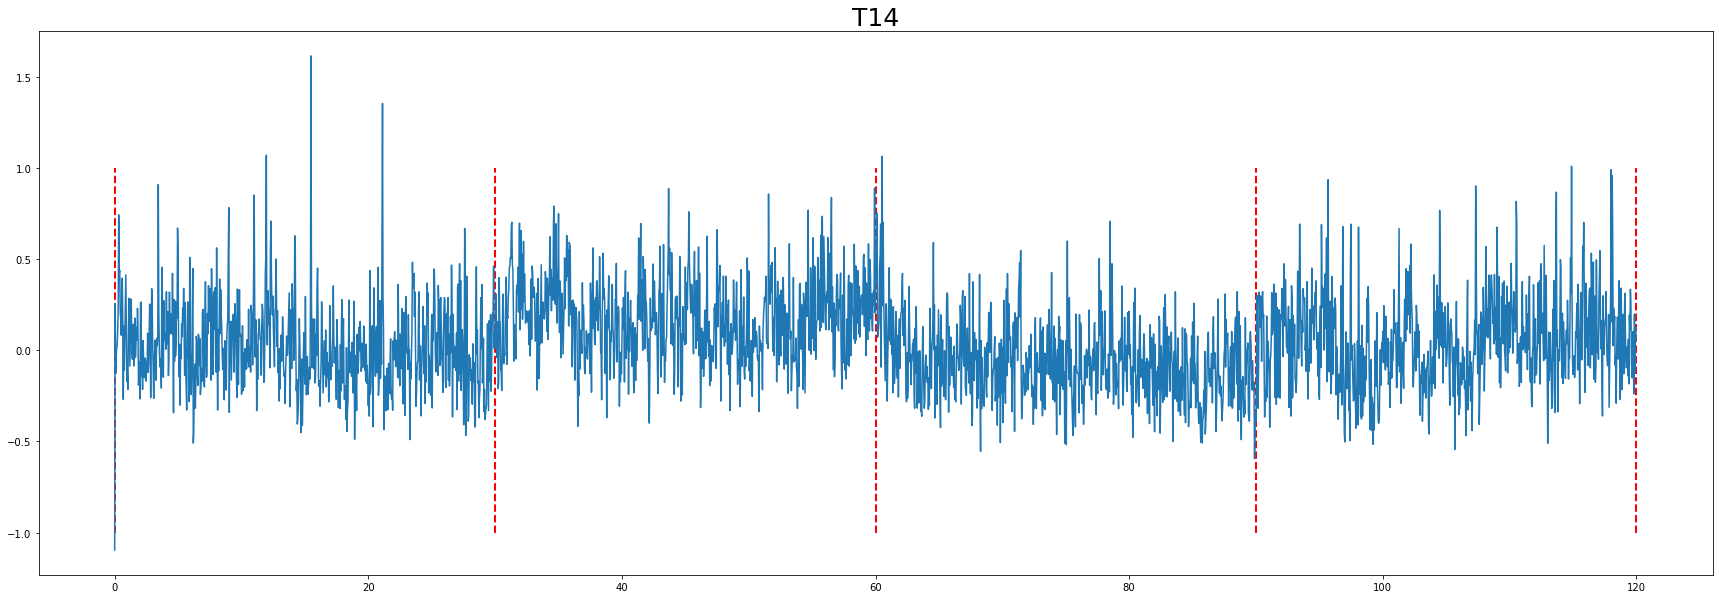

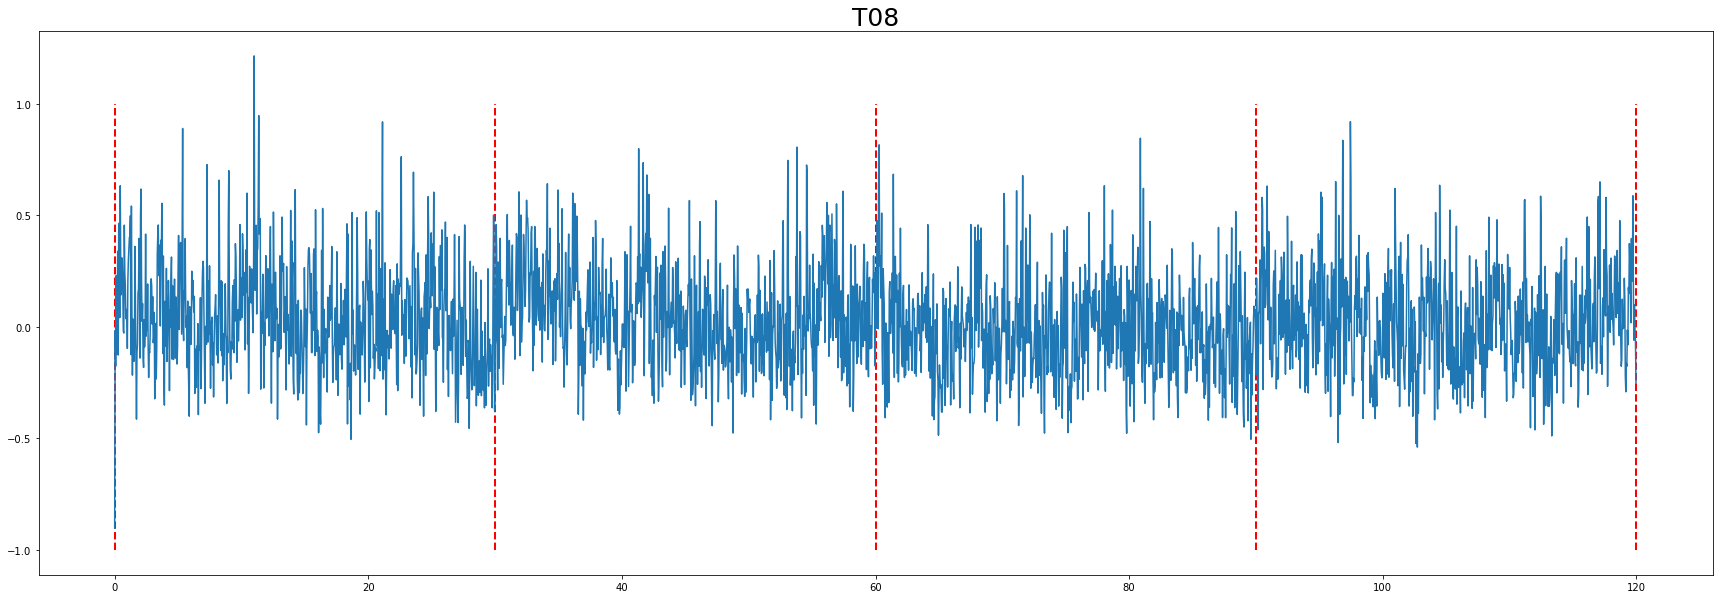

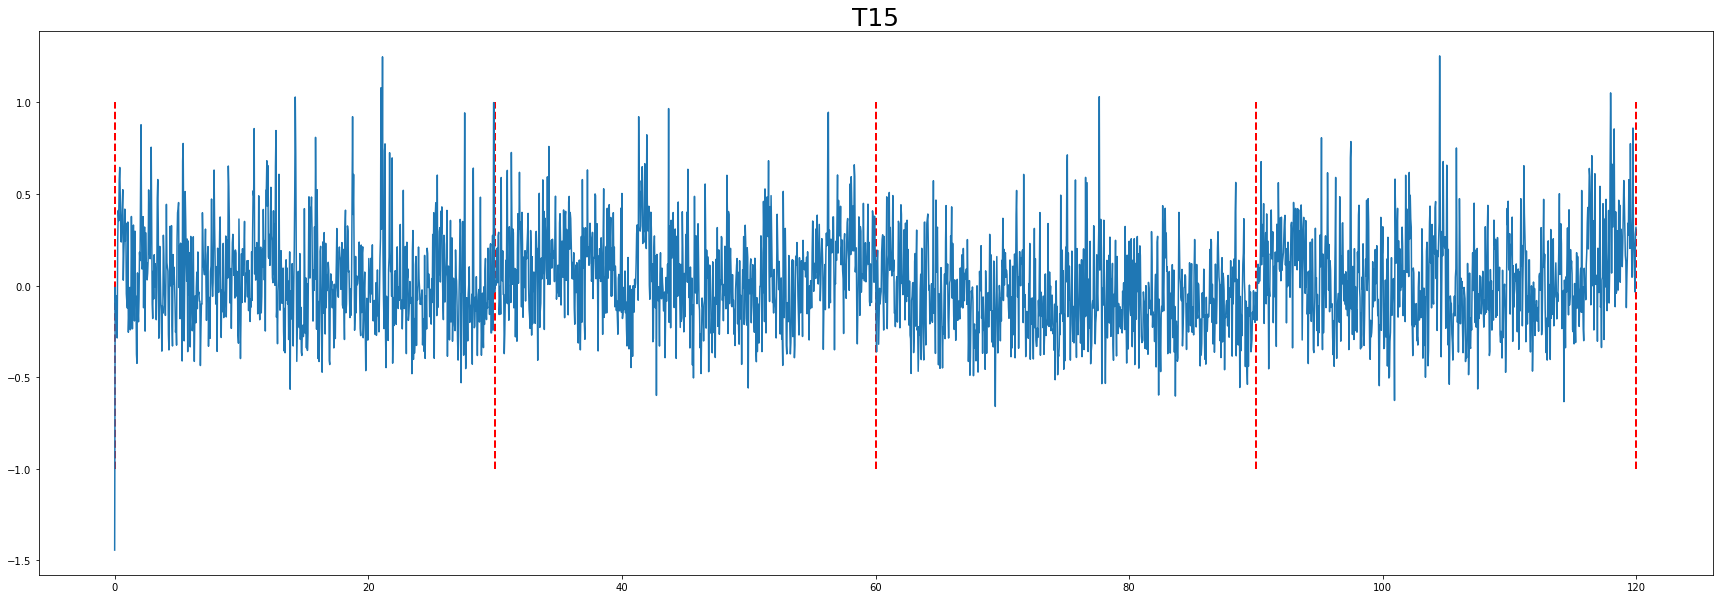

In [47]:
import matplotlib.pyplot as plt
import numpy as np

plot_elec_avg= {'F01':0 , 'F03':0 , 'F05': 0 , 'F06':0 , 'F07':0 , 'F08':0 , 'T01':0 , 'T02':0 , 'T03':0 , 'T04':0 , 'T05':0 , 'T06':0, 'T07':0, 'T09':0, 'T10':0, 'T11':0, 'T12':0 , 'T13':0 , 'T14':0, 'T08':0, 'T15':0}
time=np.arange(0, band_all_patient[0].shape[0])/(25)


time_dash=np.arange(0,150,30)

for key in plot_elec_avg.keys():
    for i in elec[key]:
        num_electrode=raw_car_all[i].ch_names.index(key)
        plot_elec_avg[key]=plot_elec_avg[key]+band_all_patient[i][:,num_electrode]
    plot_elec_avg[key]=plot_elec_avg[key]/len(elec[key])
    plt.figure(figsize=(30,10))
    plt.plot(time[:120*25],plot_elec_avg[key][:120*25])
    plt.vlines(time_dash, ymin=-1*np.ones(time_dash.shape), ymax=np.ones(time_dash.shape), colors='red', ls='--', lw=2, label='vline_multiple - partial height')
    plt.title(str(key),fontsize=25)
    plt.show()
   
    






### Find raw_data and band_all_patient for fs = 250 HZ (for patients have common electrode) : uncomment all below comment and comment "subject='01' "

### find hilbert transform of one data : comment like below

C:\Users\Sharif\AppData\Local\Temp/ipykernel_9180/858277832.py:18: FutureWarning: extension should start with a period ".", but got: "vhdr". Prepending "." to form: ".vhdr". This will raise an exception starting with MNE-BIDS 0.12.
  bids_path = mne_bids.BIDSPath(subject=self.subject,


film


C:\Users\Sharif\AppData\Local\Temp/ipykernel_9180/858277832.py:33: FutureWarning: extension should start with a period ".", but got: "tsv". Prepending "." to form: ".tsv". This will raise an exception starting with MNE-BIDS 0.12.
  bids_path = mne_bids.BIDSPath(subject=self.subject,
C:\Users\Sharif\AppData\Local\Temp/ipykernel_9180/858277832.py:43: FutureWarning: extension should start with a period ".", but got: "tsv". Prepending "." to form: ".tsv". This will raise an exception starting with MNE-BIDS 0.12.
  bids_path = mne_bids.BIDSPath(subject=self.subject,


Picking up BIDS files done
Extracting parameters from E:/maryam.sh/sub-01/ses-iemu/ieeg/sub-01_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...
Loading BIDS data done
Getting bad electrodes done
Bad channels indicated: ['AR8', 'MFL15']
Dropped ['AR8', 'MFL15']channels
Reading 0 ... 860253  =      0.000 ...   420.045 secs...


C:\Users\Sharif\AppData\Local\Temp/ipykernel_9180/858277832.py:69: RuntimeWarning: The unit for channel(s) AH+, ECG+, EMG+, MKR1+, MKR2+, ORB+, abdo+, thor+ has changed from V to NA.
  self.raw.set_channel_types({ch_name: str(x).lower()


Remaining channels ['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR9', 'AHR1', 'AHR2', 'AHR3', 'AHR4', 'AHR5', 'AHR6', 'AHR7', 'AHR8', 'AHR9', 'PHR1', 'PHR2', 'PHR3', 'PHR4', 'PHR5', 'PHR6', 'PHR7', 'PHR8', 'PHR9', 'ITR1', 'ITR2', 'ITR3', 'ITR4', 'ITR5', 'ITR6', 'ITR7', 'ITR8', 'ITR9', 'ITR10', 'MFR1', 'MFR2', 'MFR3', 'MFR4', 'MFR5', 'MFR6', 'MFR7', 'MFR8', 'MFR9', 'MFR10', 'MFR11', 'MFR12', 'MFR13', 'MFR14', 'MFR15', 'FOR1', 'FOR2', 'FOR3', 'FOR4', 'FOR5', 'FOR6', 'FOR7', 'FOR8', 'FOR9', 'FOR10', 'FOR11', 'FOR12', 'FOR13', 'FOR14', 'FOR15', 'MFL1', 'MFL2', 'MFL3', 'MFL4', 'MFL5', 'MFL6', 'MFL7', 'MFL8', 'MFL9', 'MFL10', 'MFL11', 'MFL12', 'MFL13', 'MFL14', 'ACR1', 'ACR2', 'ACR3', 'ACR4', 'ACR5', 'ACR6', 'ACR7', 'ACR8', 'ACR9', 'ACR10', 'ACR11', 'ACR12', 'AHL1', 'AHL2', 'AHL3', 'AHL4', 'AHL5', 'AHL6', 'AHL7', 'AHL8', 'AHL9']
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    5.1s finished


Notch filter done
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
CAR done
Used Annotations descriptions: ['Stimulus/end task', 'Stimulus/music', 'Stimulus/speech']
Reading events done


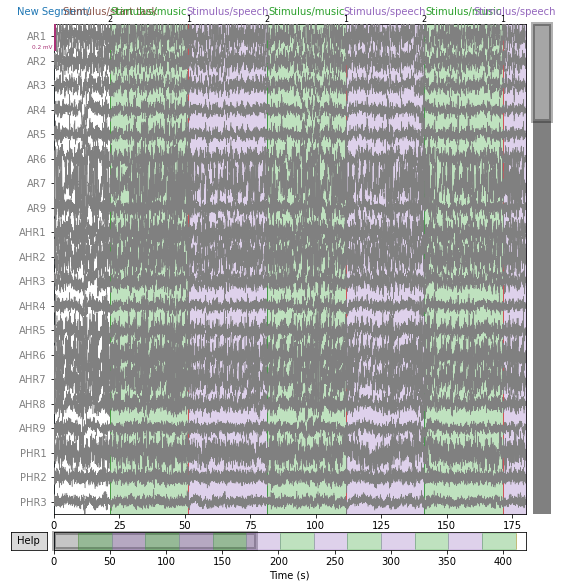

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    4.7s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 3381 samples (1.651 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    4.3s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 3381 samples (1.651 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    4.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 27.00 Hz)
- Filter length: 2081 samples (1.016 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    4.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 60 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 451 samples (0.220 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 101 out of 101 | elapsed:    4.5s finished


Extracting band envelopes done


In [91]:

import mne_bids
import mne
import pandas as pd
import os
import numpy as np
from collections import OrderedDict
from ieeg_fmri_validation.utils import resample, smooth_signal, zscore


num=63
bids_dir='E:\maryam.sh'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')
subject=subjects[0]
acqs=mne_bids.get_entity_vals(os.path.join(bids_dir, 'sub-' + subject, 'ses-iemu', 'ieeg'),'acquisition')
acq=acqs[0]
#band_all_patient_same=[]
#raw_car_all_same=[]
subjects2=subjects[:num]
subject='01'
#for subject in same_patient2:
 #   if 'iemu' in mne_bids.get_entity_vals(os.path.join(bids_dir, 'sub-' + subject), 'session'):
s=SubjectDataset(bids_dir,subject,acquisition=acq)
raw_car=s.preprocess()
events,events_id=s.extract_events()
bands2,bands3,bands4,band5=s.extract_bands()
        #band_all_patient_same.append(band5['gamma'])
        #raw_car_all_same.append(raw_car)

### plot spectrum of hilbert transform of data in gamma band

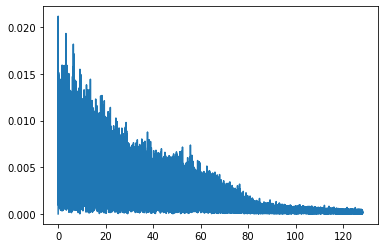

In [94]:
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import numpy as np
fs = 2048

s1=bands3['gamma'][:,1]
s2=s1-np.mean(s1)
s_ff=fft(s2)
n_fft =s_ff.shape[0]
f= np.linspace(0, 2*np.pi, n_fft)*fs/(2*np.pi)

plt.plot(f[:10000*5],np.abs(s_ff)[:10000*5])

### find real number of patient

In [ ]:
bids_dir='E:\maryam.sh'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')
acqs=mne_bids.get_entity_vals(os.path.join(bids_dir, 'sub-' + subject, 'ses-iemu', 'ieeg'),'acquisition')
acq=acqs[0]
subject_list=[]
subjects2=subjects[:num]
for subject in subjects2:
     if 'iemu' in mne_bids.get_entity_vals(os.path.join(bids_dir, 'sub-' + subject), 'session'):
            subject_list.append(subject)
    

### plot average gamma band for common electrodes ( fs =250 HZ)


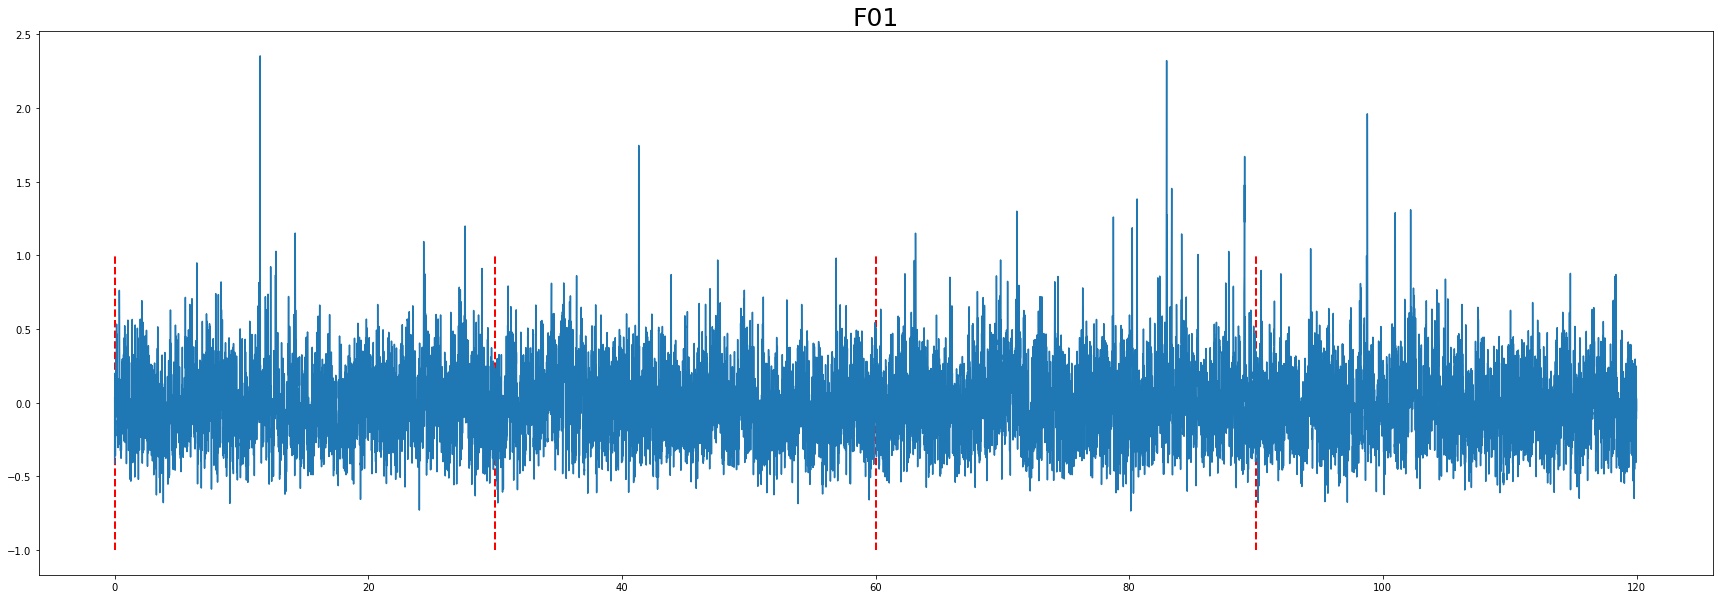

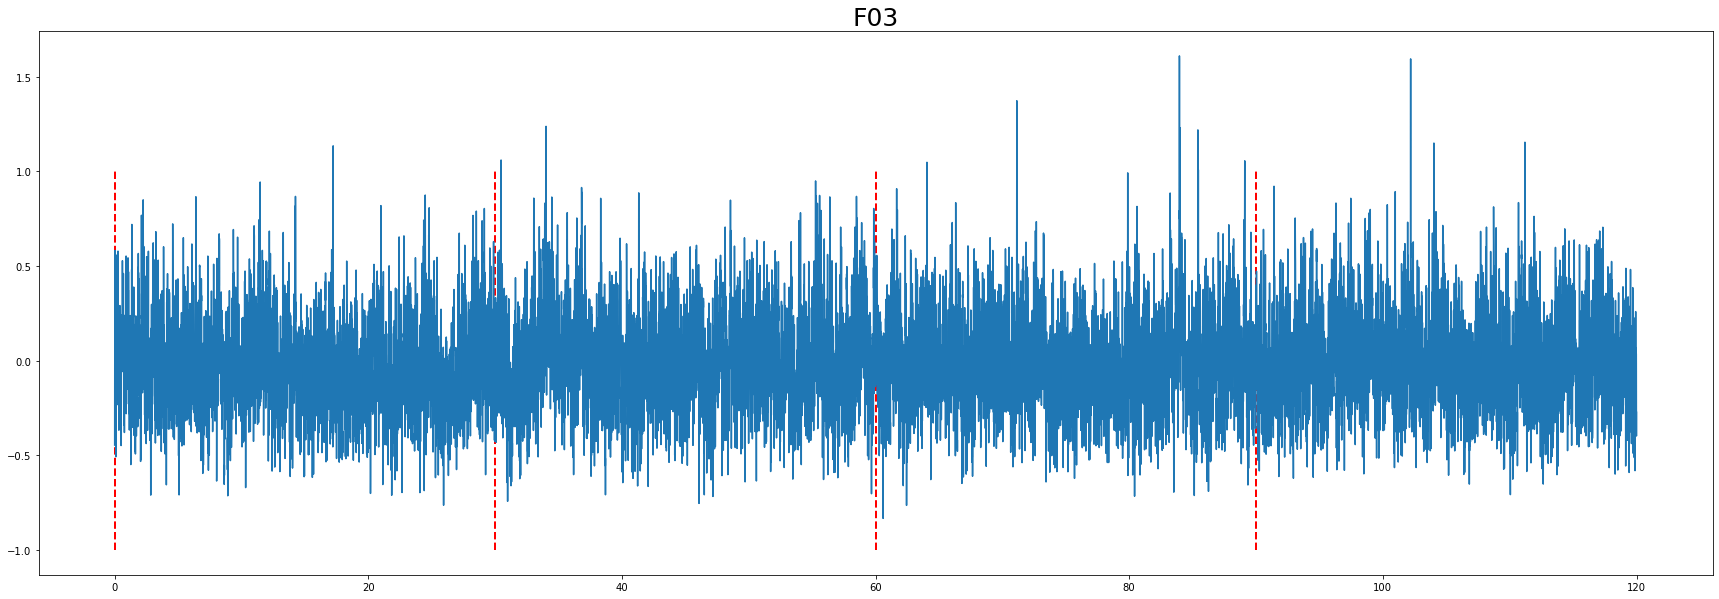

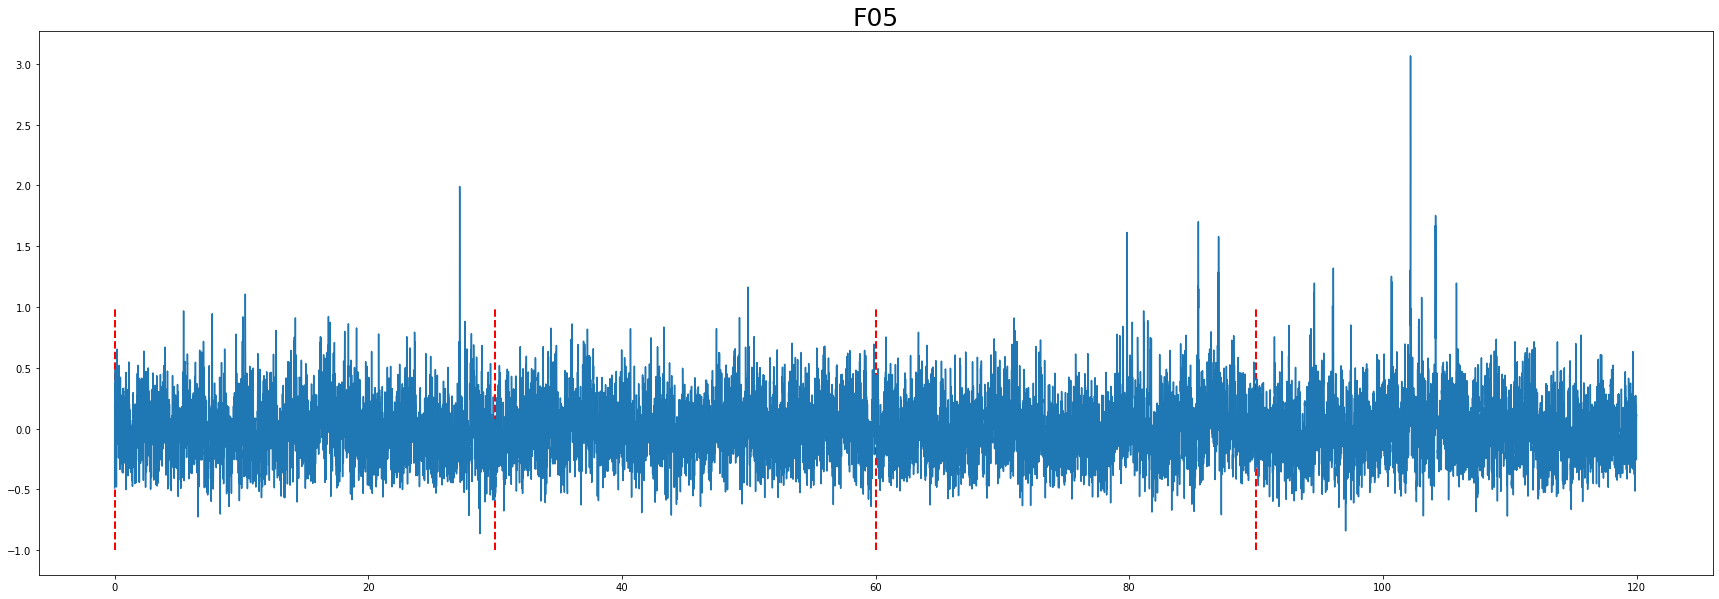

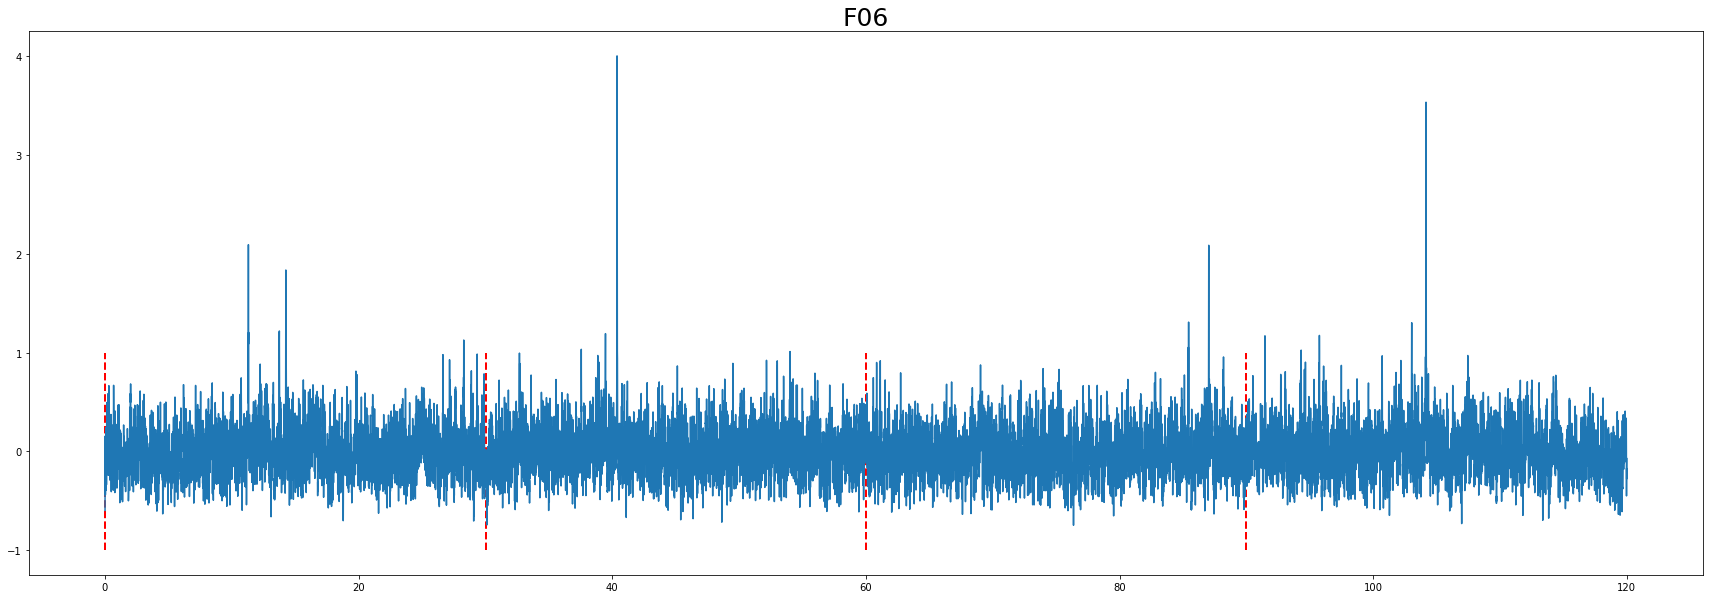

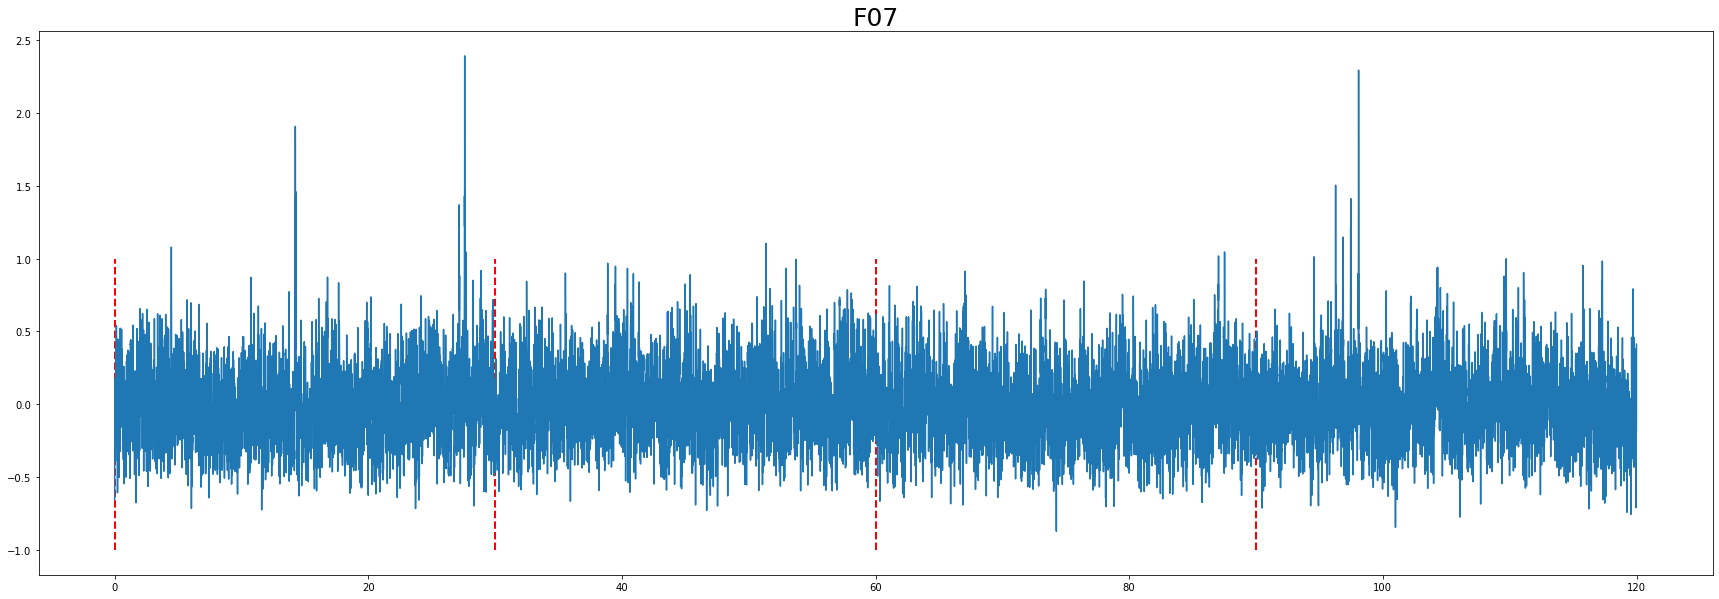

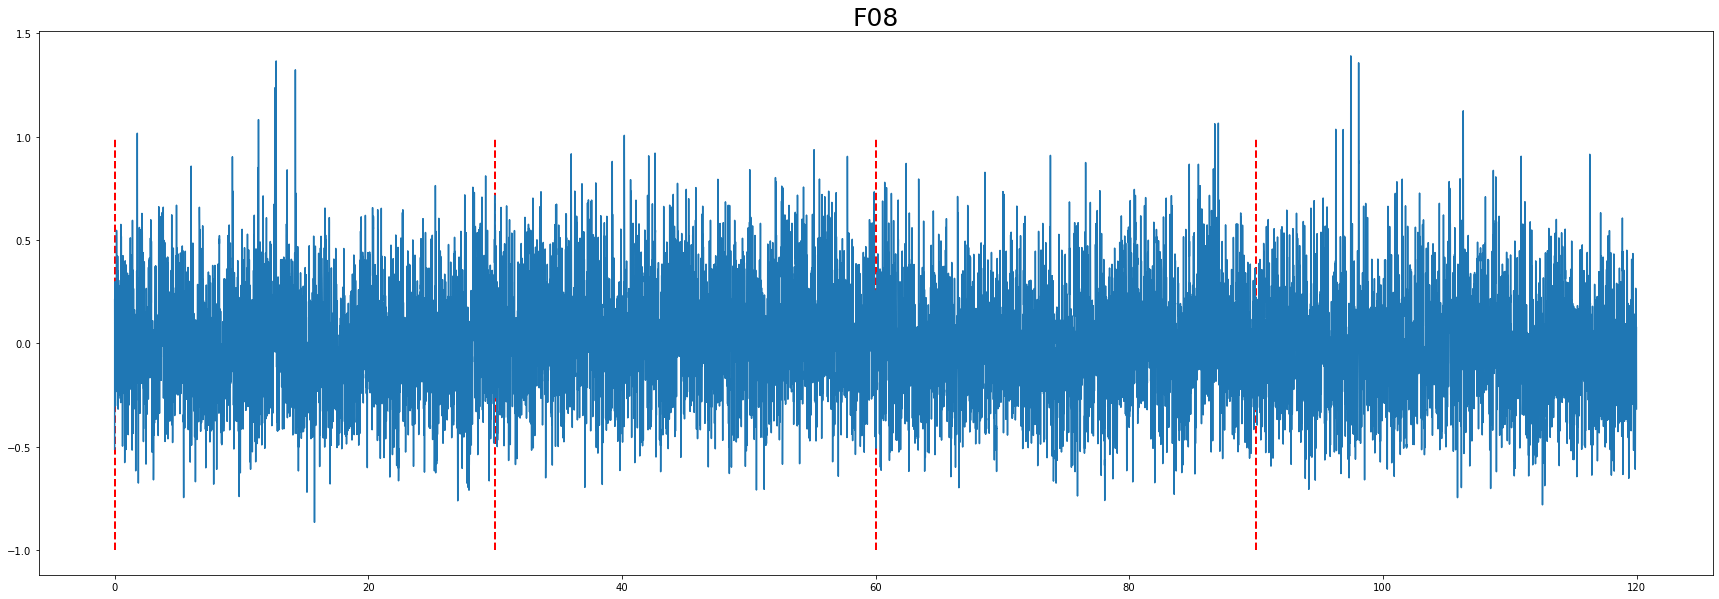

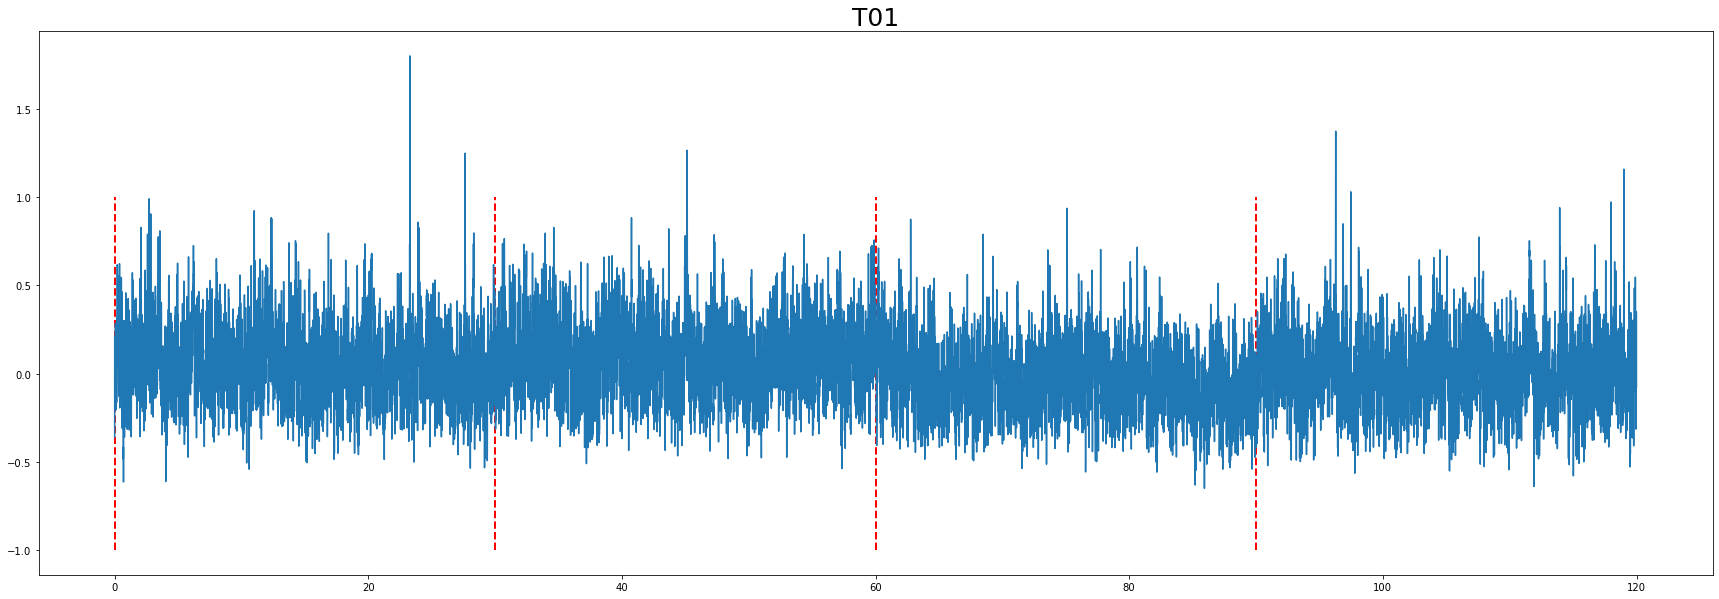

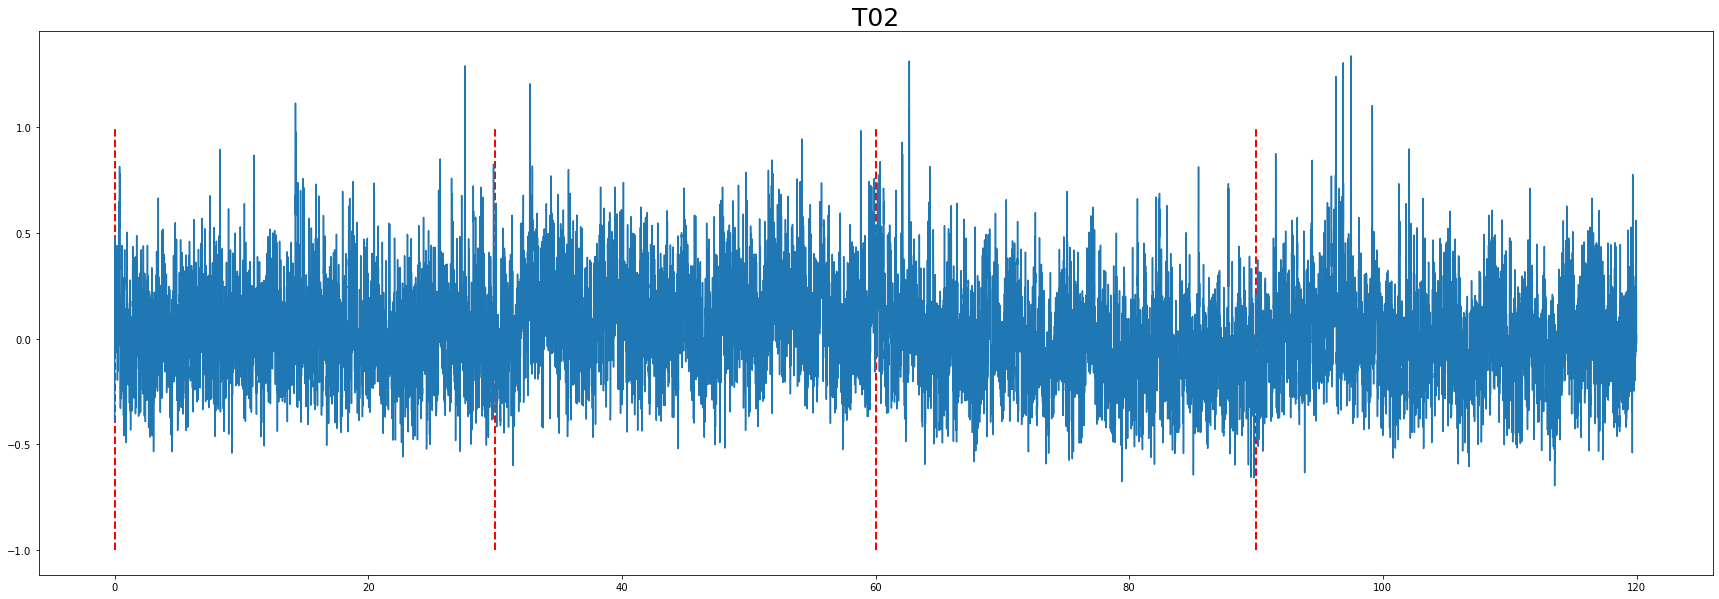

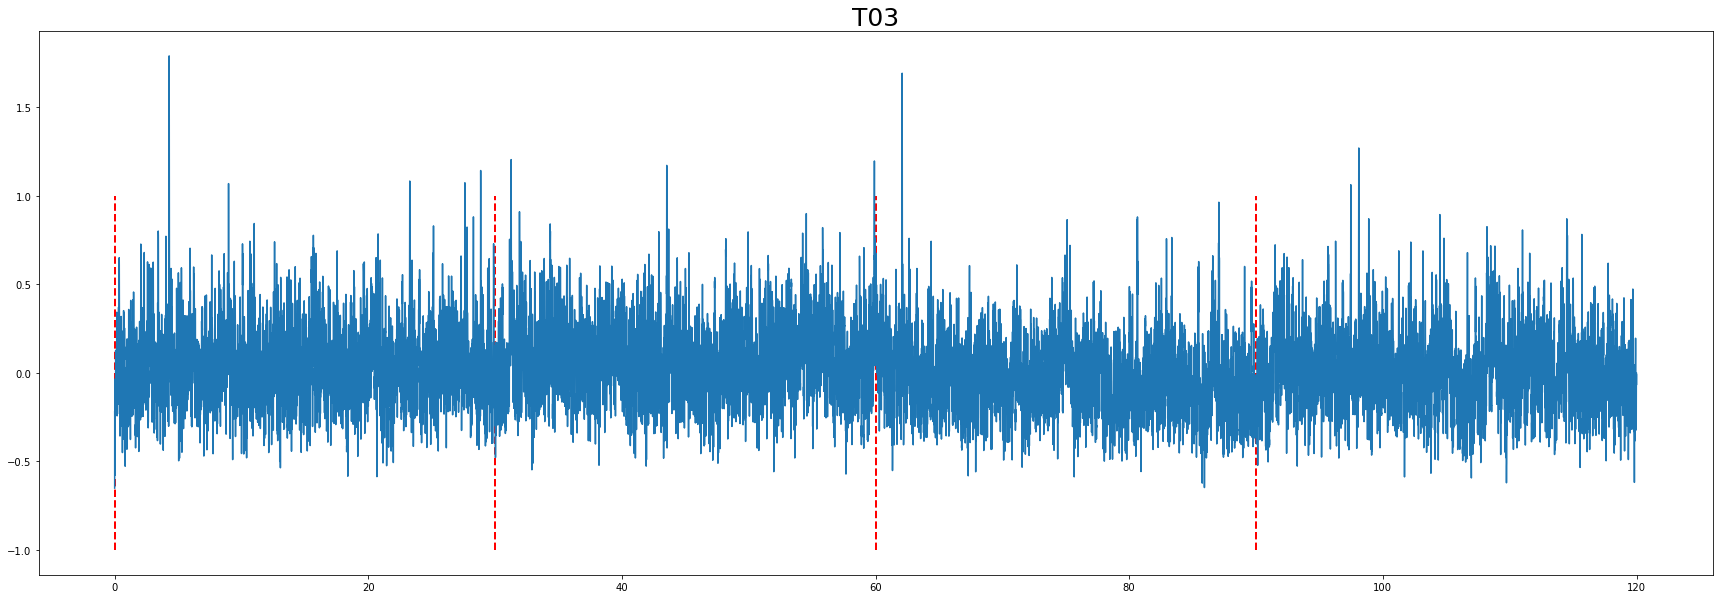

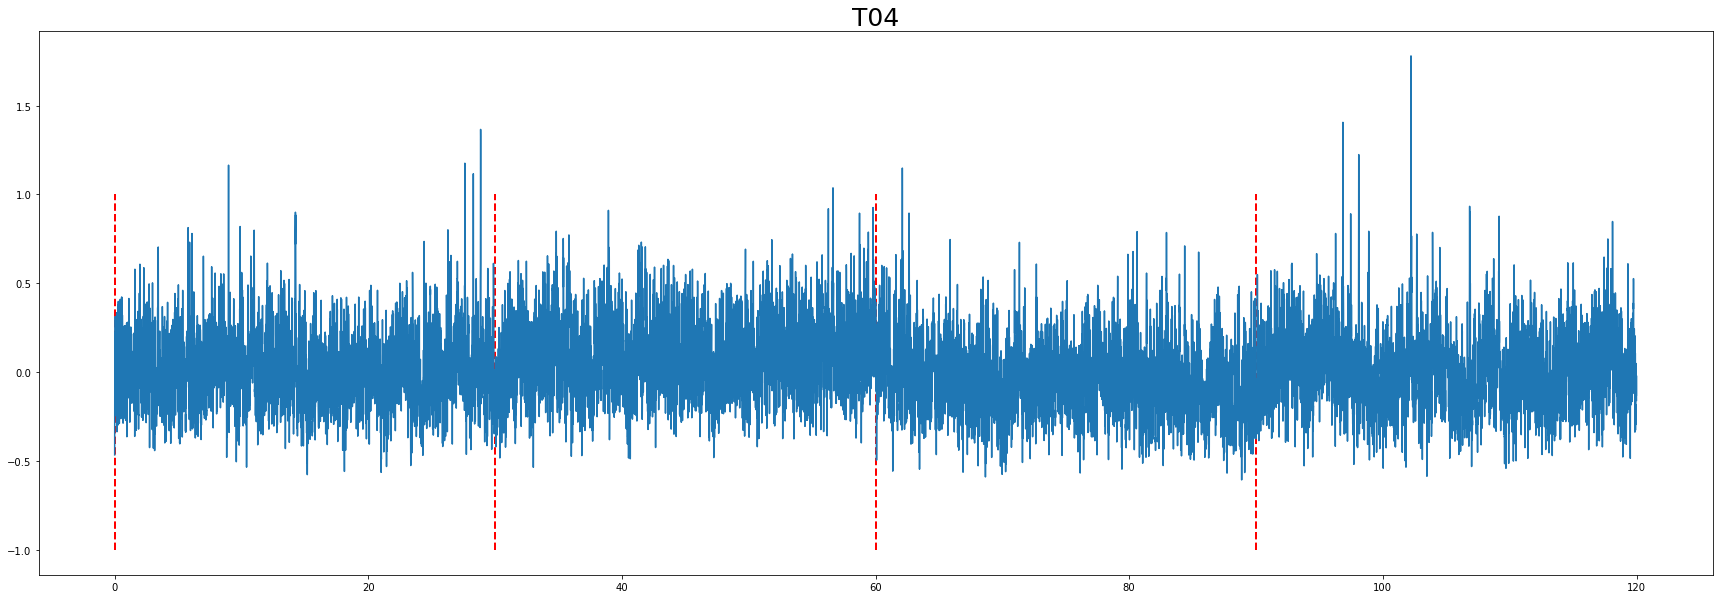

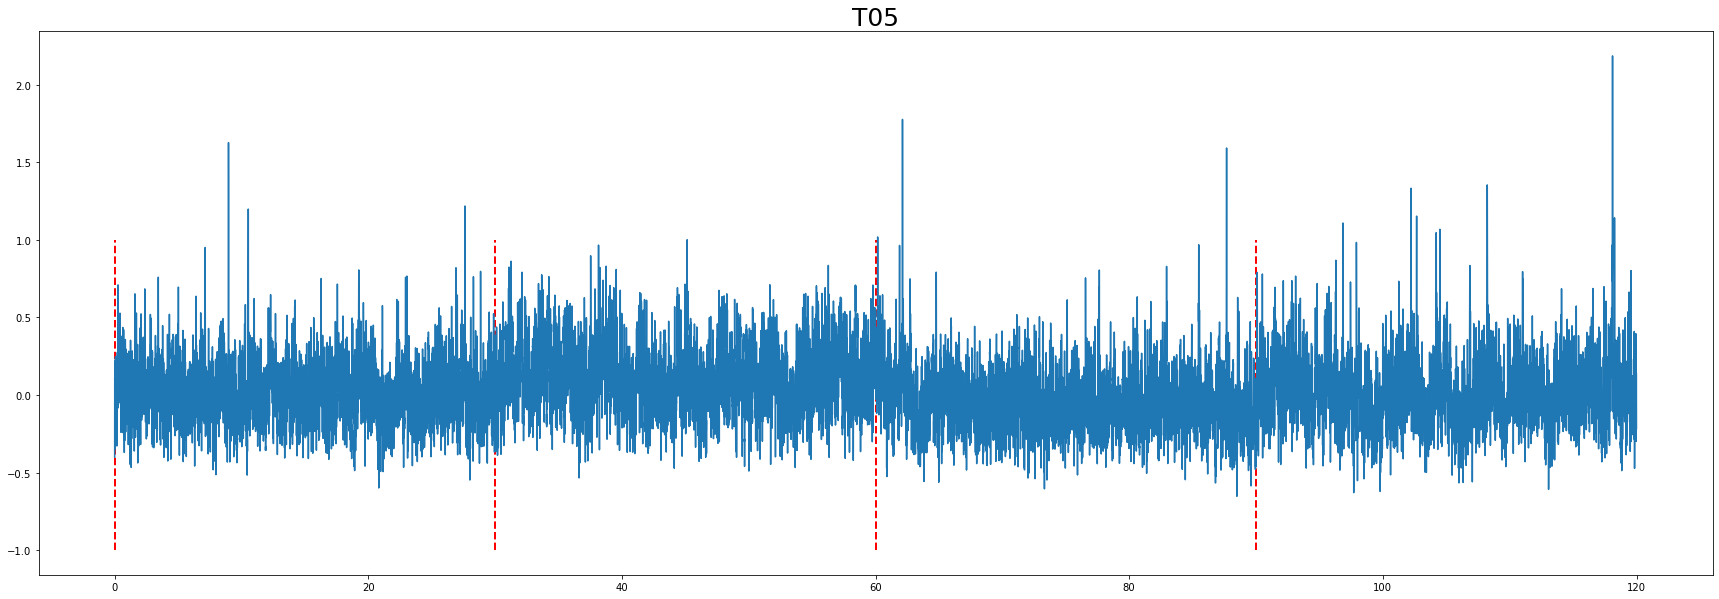

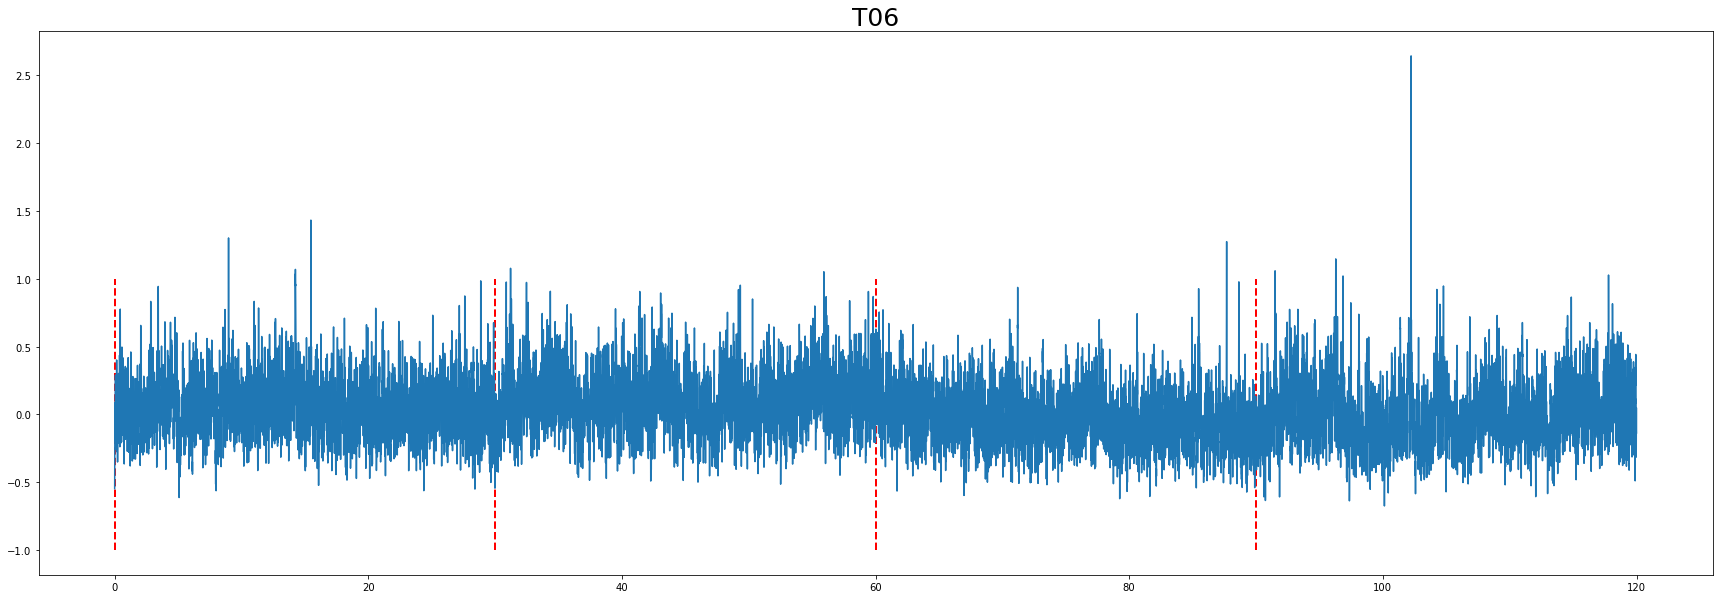

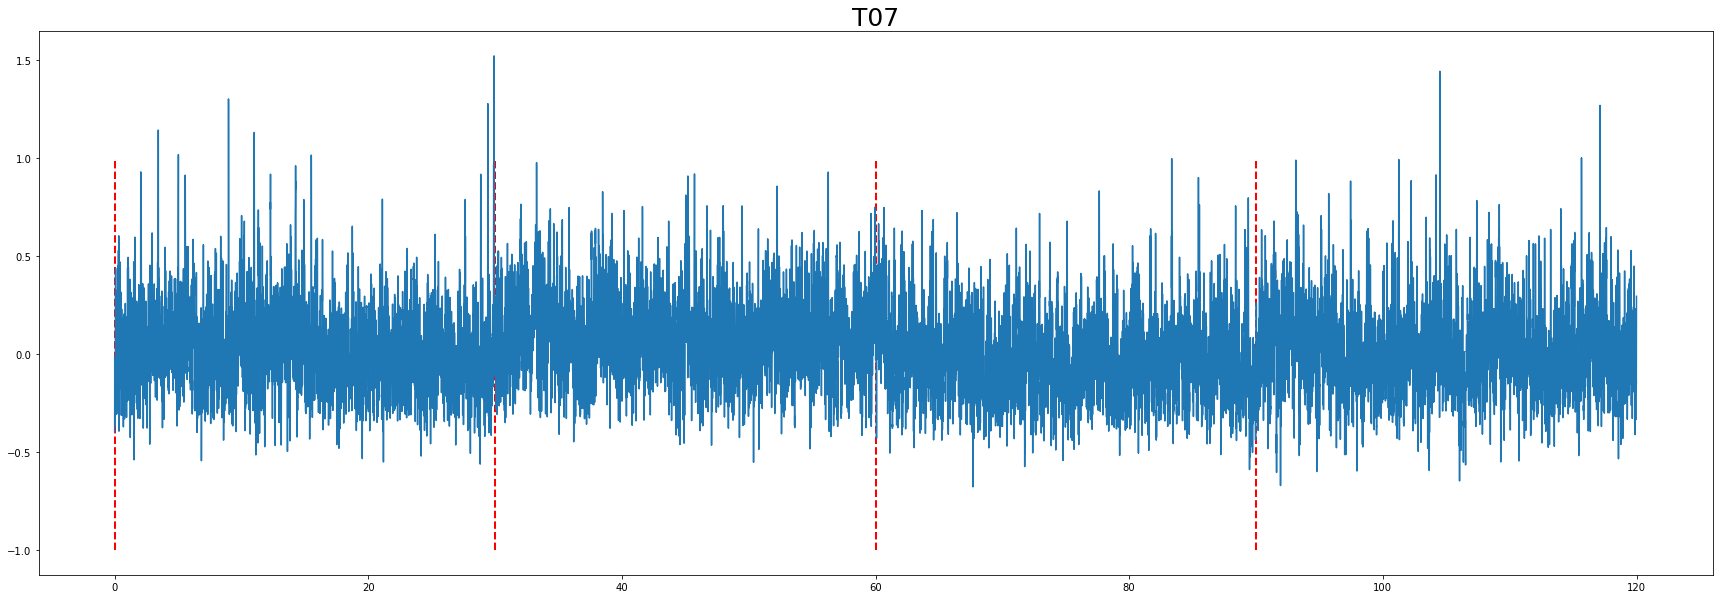

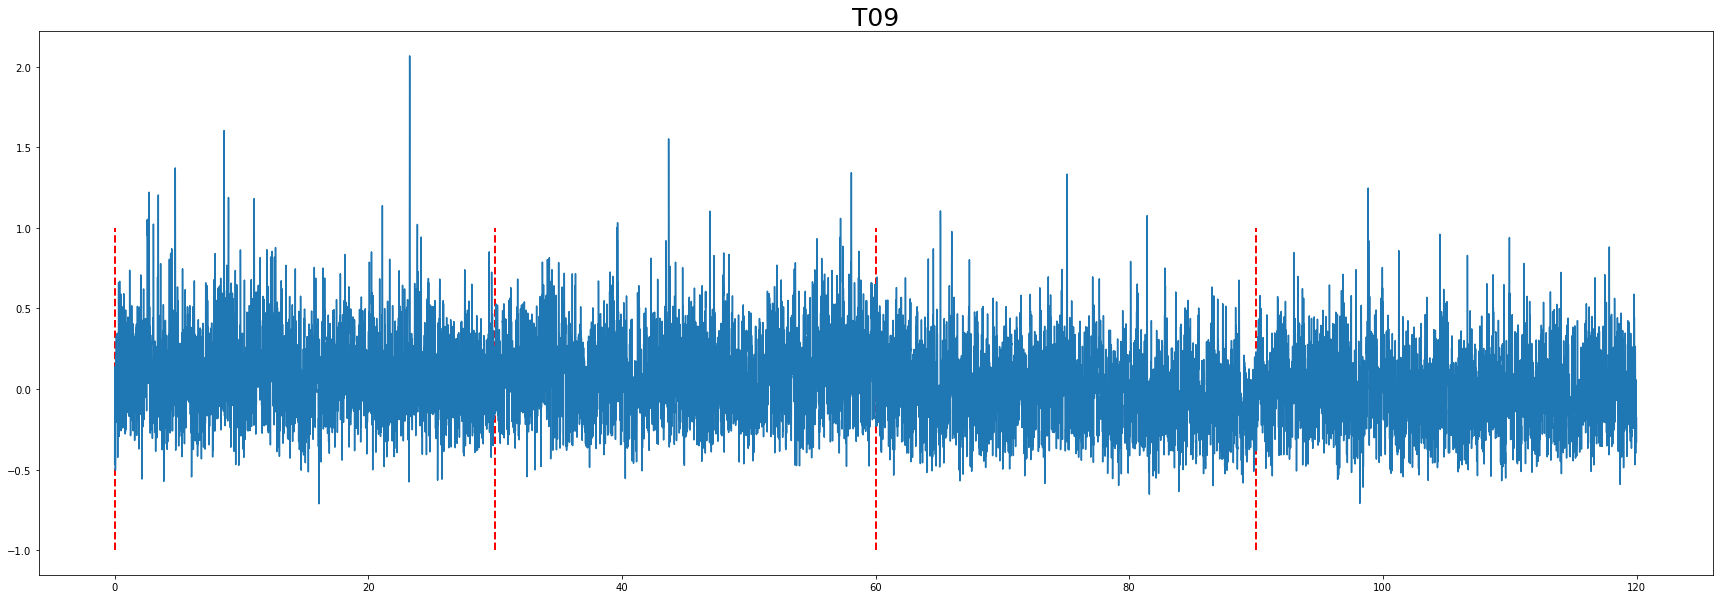

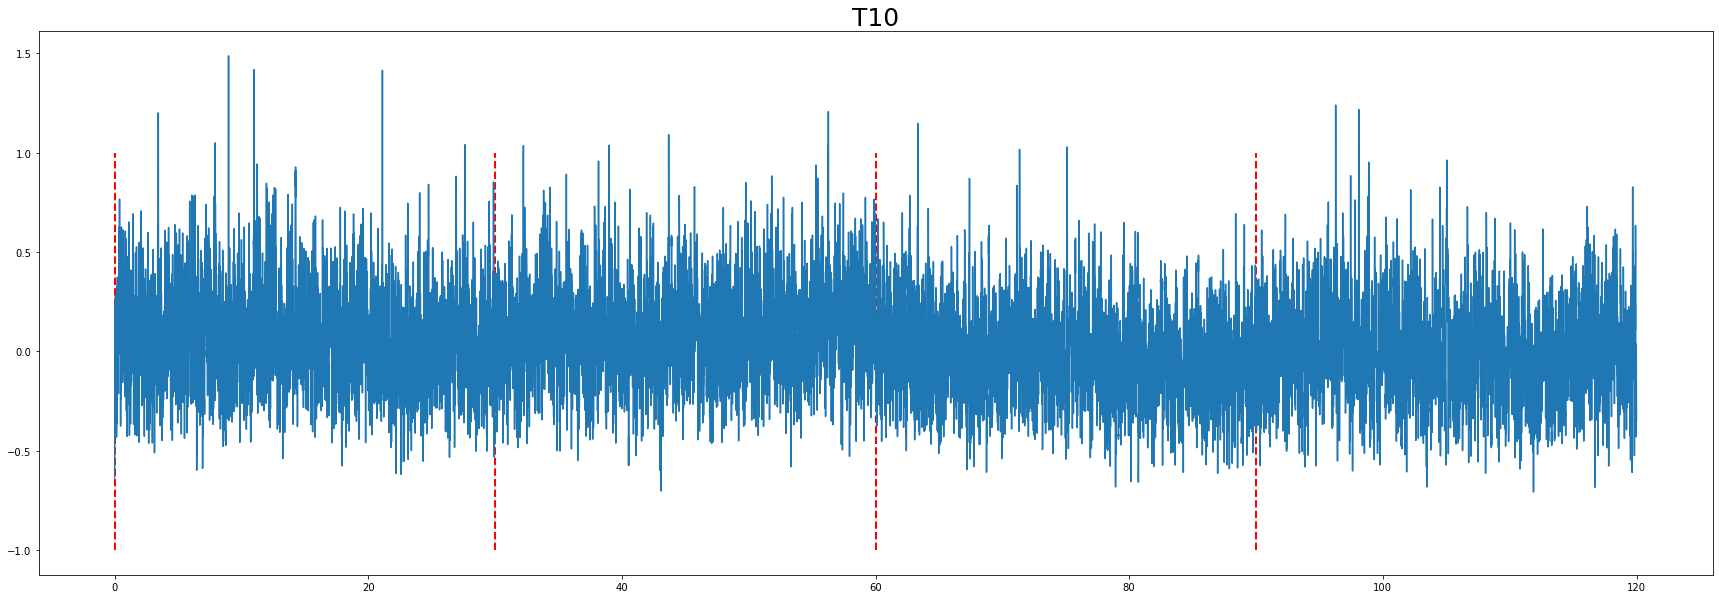

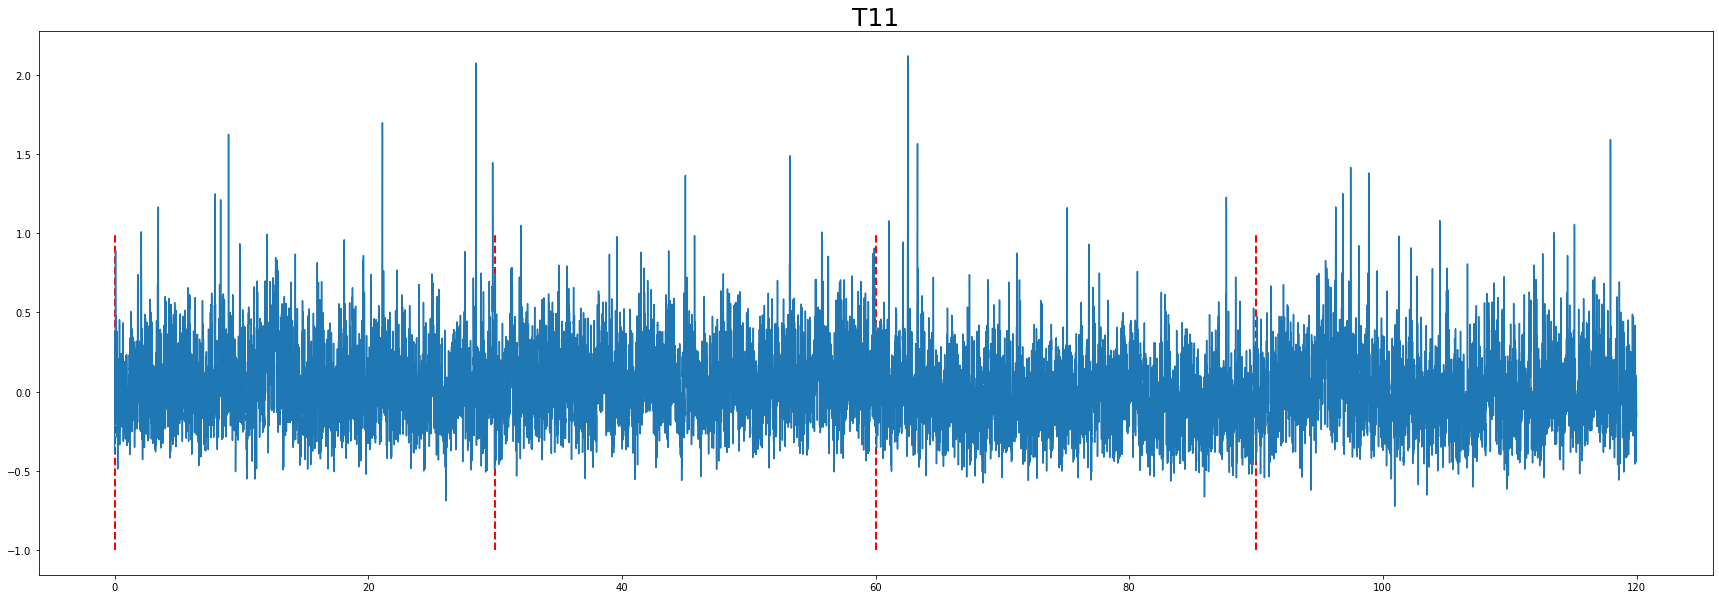

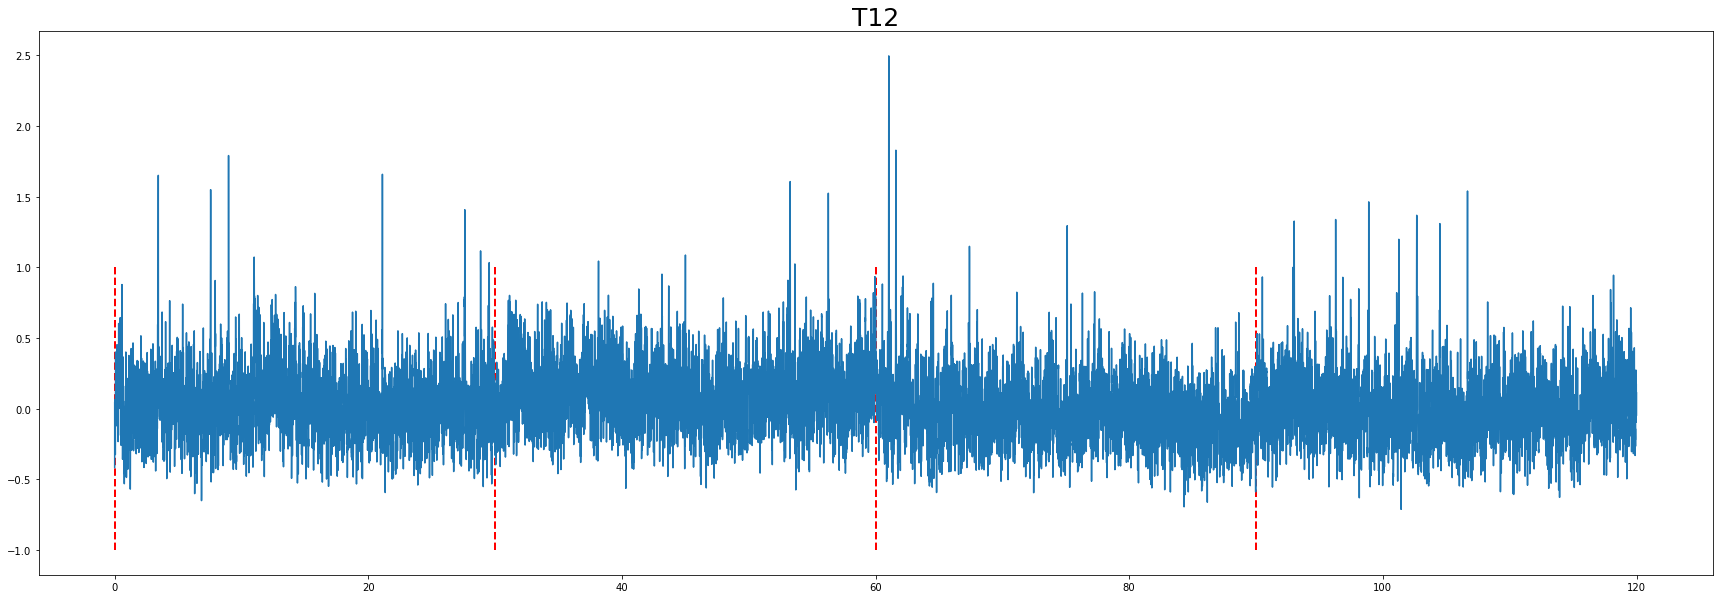

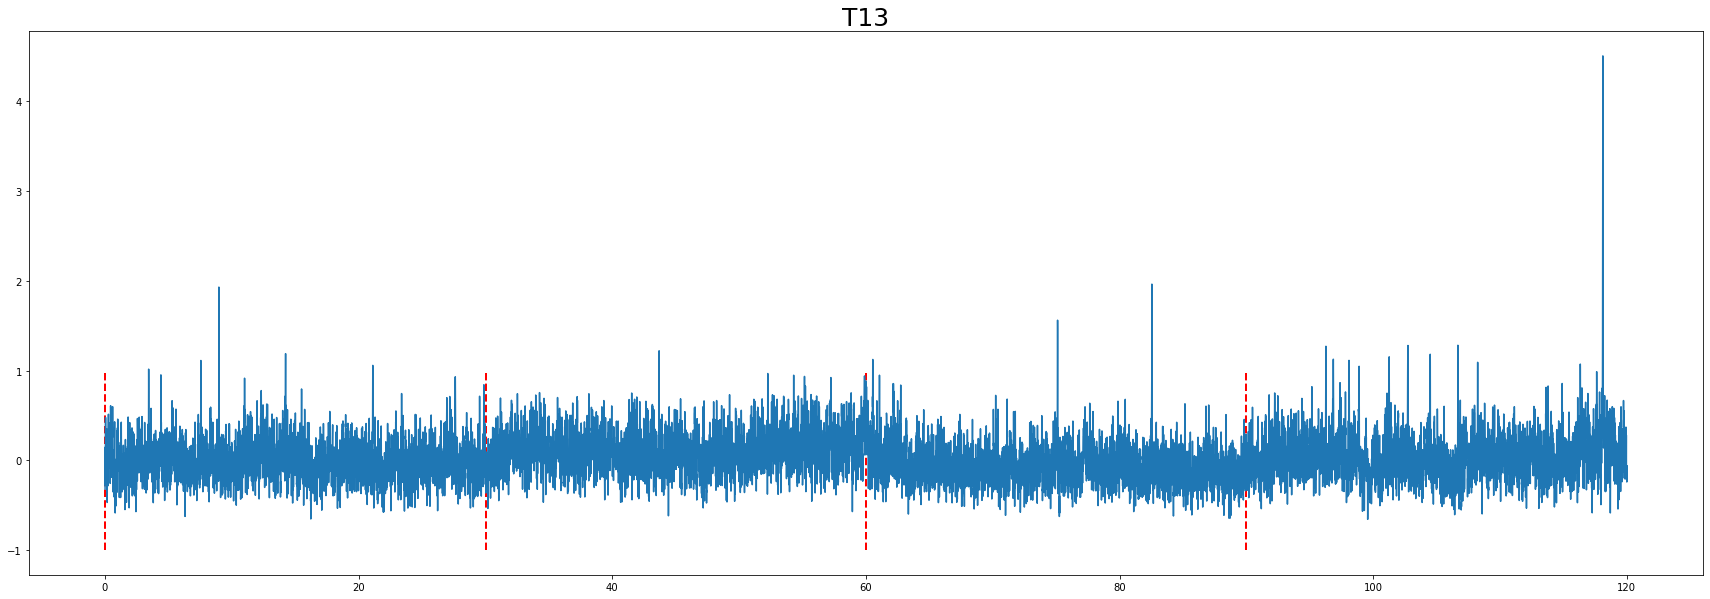

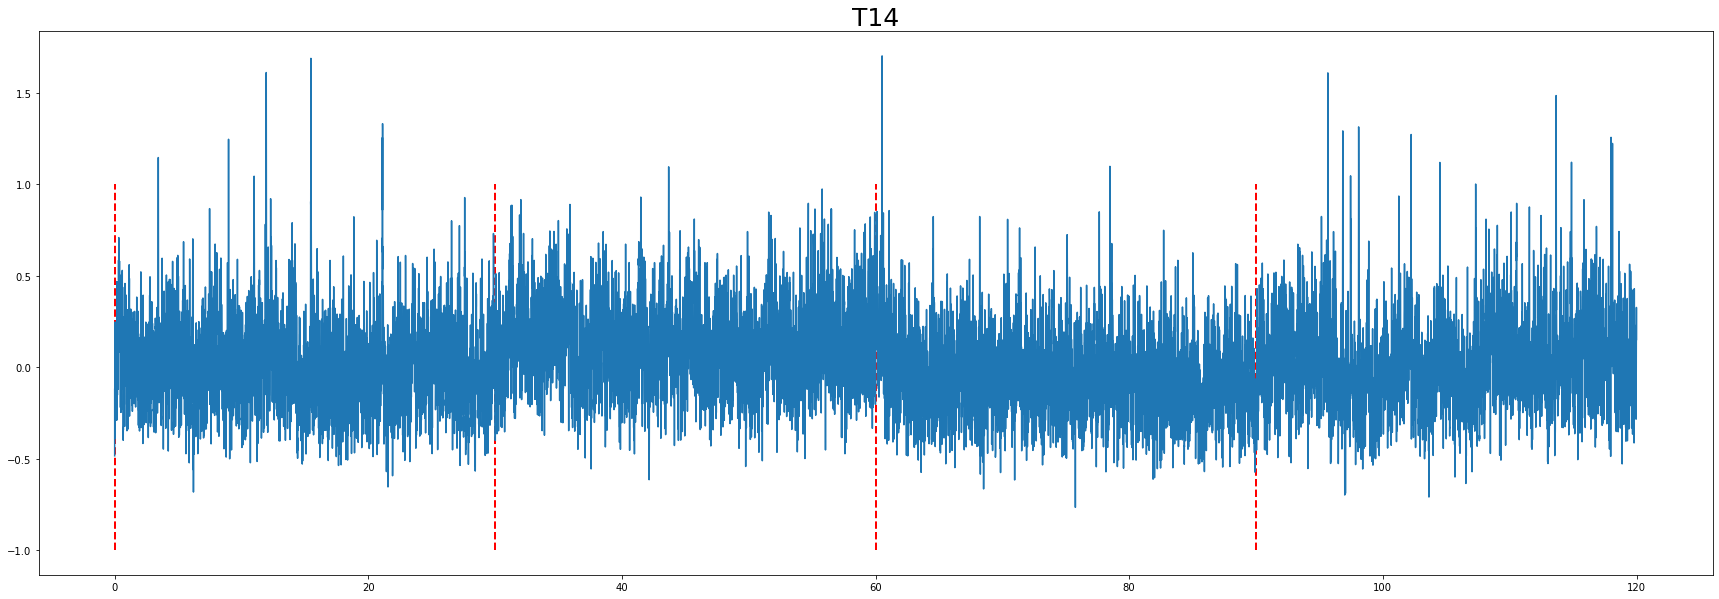

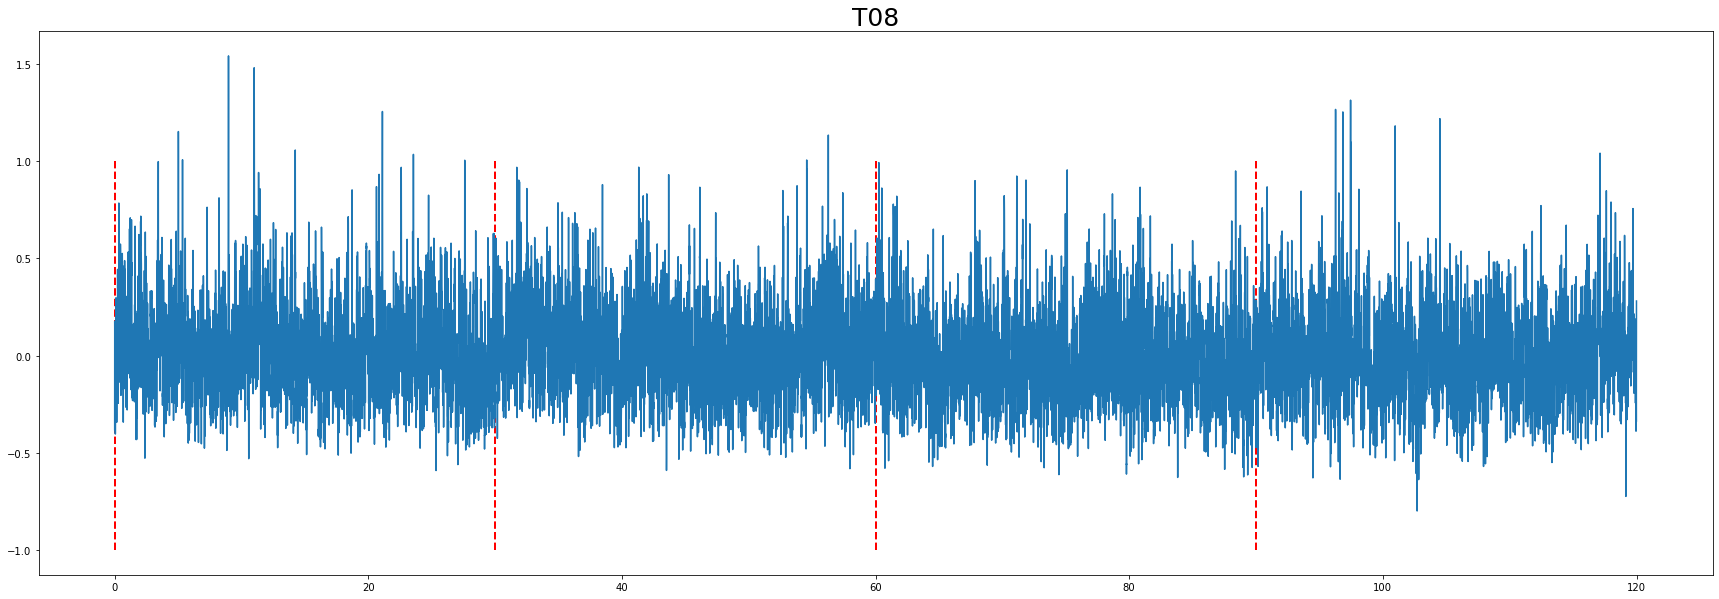

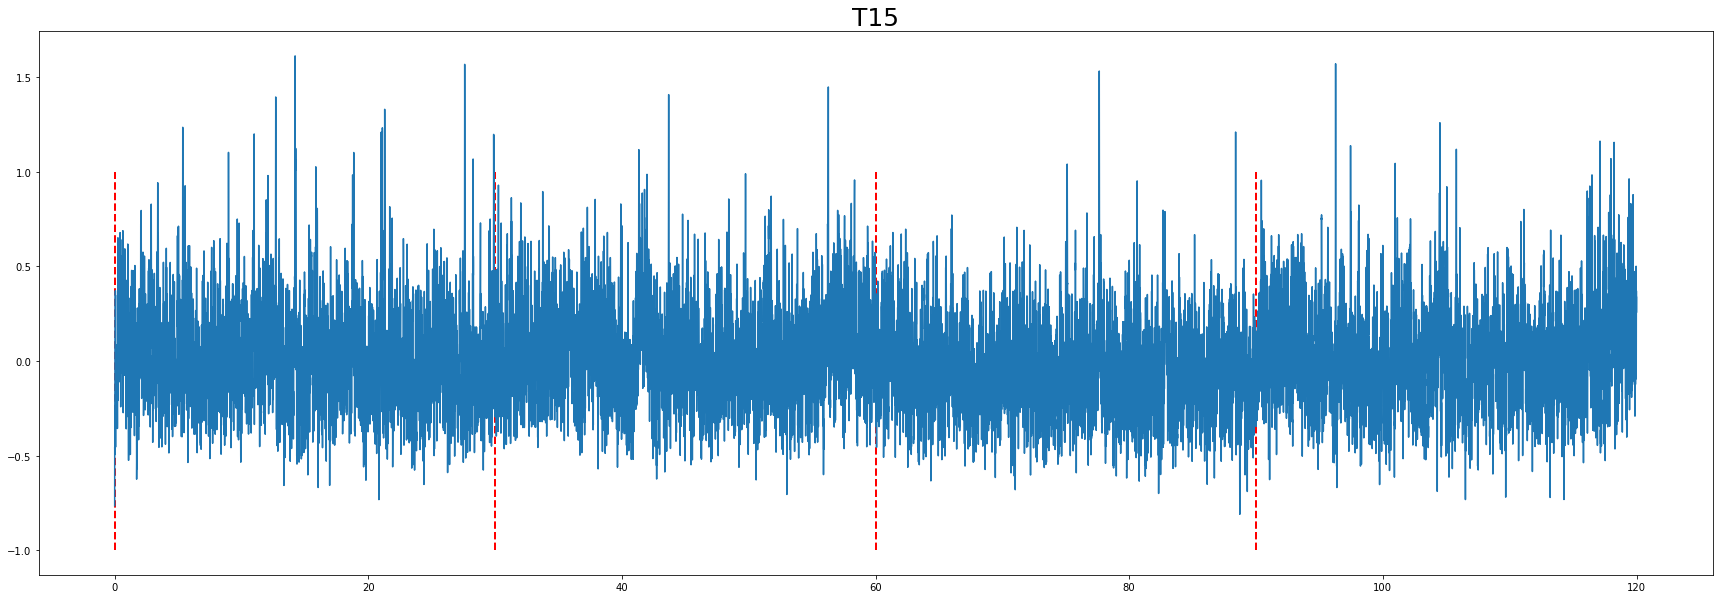

In [96]:
import matplotlib.pyplot as plt
import numpy as np

same_patient=[]
same_patient2=[]        

plot_elec_avg_same= {'F01':0 , 'F03':0 , 'F05': 0 , 'F06':0 , 'F07':0 , 'F08':0 , 'T01':0 , 'T02':0 , 'T03':0 , 'T04':0 , 'T05':0 , 'T06':0, 'T07':0, 'T09':0, 'T10':0, 'T11':0, 'T12':0 , 'T13':0 , 'T14':0, 'T08':0, 'T15':0}

for key in plot_elec_avg_same.keys():    
    for i in elec[key]:
        same_patient.append(subject_list[i])

#remove duplicate elements in same_patient
for i in same_patient: 
    if i not in same_patient2: 
        same_patient2.append(i) 
        

plot_elec_avg_same= {'F01':0 , 'F03':0 , 'F05': 0 , 'F06':0 , 'F07':0 , 'F08':0 , 'T01':0 , 'T02':0 , 'T03':0 , 'T04':0 , 'T05':0 , 'T06':0, 'T07':0, 'T09':0, 'T10':0, 'T11':0, 'T12':0 , 'T13':0 , 'T14':0, 'T08':0, 'T15':0}
time=np.arange(0, band_all_patient_same[0].shape[0])/(250)

time_dash=np.arange(0,120,30)


for key in plot_elec_avg_same.keys():
    for i in elec[key]:
        i2=subject_list[i]
        i3=same_patient2.index(str(i2))
        num_electrode=raw_car_all_same[i3].ch_names.index(key)
        plot_elec_avg_same[key]=plot_elec_avg_same[key]+band_all_patient_same[i3][:,num_electrode]
    plot_elec_avg_same[key]=plot_elec_avg_same[key]/len(elec[key])
    plt.figure(figsize=(30,10))
    plt.plot(time[:120*250],plot_elec_avg_same[key][:120*250])
    plt.vlines(time_dash, ymin=-1*np.ones(time_dash.shape), ymax=np.ones(time_dash.shape), colors='red', ls='--', lw=2, label='vline_multiple - partial height')
    plt.title(str(key),fontsize=25)
    plt.show()
   

### 3-1.plot preprocess data

In [ ]:
import matplotlib.pyplot as plt
raw_data=raw_car.get_data()
fs = raw_car.info['sfreq']
time = np.arange(0, raw_data.shape[1])/(fs)
print('Fs =',fs)
print('shape of raw_data is =', raw_data.shape)
print('time duration is ',raw_data.shape[1],'/',fs,'=',raw_data.shape[1]/fs,'s')
plt.figure(figsize=(20,3))
plt.plot(time, raw_data[1,:])
plt.show()

### plot Zscore of HFB band of one electrode

In [ ]:
import matplotlib.pyplot as plt

time=np.arange(0, band5['gamma'].shape[0])/(25)
plt.figure(figsize=(30,10))
plt.plot(time[:4500],band5['gamma'][:4500,1])
plt.show()

### plot HFB band of one electrode (without Zscore)

In [ ]:
import matplotlib.pyplot as plt

time=np.arange(0, bands4['gamma'].shape[0])/(25)
plt.figure(figsize=(20,3))
plt.plot(time,bands4['gamma'][:,1])
plt.show()

### regression with autoregressive

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# Fit the AR model
lags = 10
model = AutoReg(bands5_mean_elec,lags = lags)
results = model.fit()

# Create the plot
fig, ax = plt.subplots(figsize=(30, 20))
ax.plot(bands5_mean_elec[:1500], color='blue', alpha=0.7, label='Data')
ax.plot(results.fittedvalues[:1500], color='red', alpha=0.7, label='AR model')
ax.legend()
plt.show()